# Analys Sentiment Datasets - Correlation Analysis and EDA

## Phase 1: Data Imports and Cleaning

### 1.0: Setup and Imports

In [1]:
# 1.0: Centralized Imports and Installs
print("1.0: Centralized Imports and Installs")
print("-"*30)
import sys

# --- Step 1: Clean-up potential conflicting installs ---
print("Uninstalling any previous xgboost versions to ensure a clean state...")
# This removes both the standard and cpu-only packages to prevent conflicts.
!{sys.executable} -m pip uninstall xgboost xgboost-cpu -y --quiet
print("Cleanup complete.")

# --- Step 2: Install all required Python packages ---
# This installs the full xgboost package, which includes CUDA support by default.
print("Installing all required packages (pandas, numpy, matplotlib, seaborn, scikit-learn, xgboost)...")
!{sys.executable} -m pip install pandas numpy matplotlib seaborn scikit-learn xgboost --quiet
print("All packages have been installed.")

# --- Step 3: Critical Kernel Restart ---
# This is a mandatory step after installing libraries that interact with system
# hardware (like the GPU via XGBoost) to ensure they are loaded correctly.
print("\n" + "-"*30)
print("CRITICAL STEP")
print("Installation complete. You MUST now restart the Jupyter kernel.")
print("In VS Code / Jupyter: Find the 'Restart' button for the kernel (a circular arrow icon).")
print("After restarting, you can run all subsequent cells from 1.1 onward.")
print("-"*30)

1.0: Centralized Imports and Installs
------------------------------
Uninstalling any previous xgboost versions to ensure a clean state...
Cleanup complete.
Installing all required packages (pandas, numpy, matplotlib, seaborn, scikit-learn, xgboost)...


All packages have been installed.

------------------------------
CRITICAL STEP
Installation complete. You MUST now restart the Jupyter kernel.
In VS Code / Jupyter: Find the 'Restart' button for the kernel (a circular arrow icon).
After restarting, you can run all subsequent cells from 1.1 onward.
------------------------------



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [35]:
# 1.1: Importing Libraries and Verifying GPU Environment
print("1.1: Importing libraries and Verifying Environment")
print("-"*30)

# --- Standard library imports (run AFTER kernel restart) ---
import sys
import os
import pickle
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error

# --- Enable the experimental imputer BEFORE importing it ---
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
# --- Import the private utility function for the monkey-patch ---
from sklearn.utils import _safe_indexing
# -------------------------------------------------------------
from xgboost import XGBRegressor

print(f"Python Executable: {sys.executable}")
print(f"XGBoost Version:   {xgb.__version__}")
print("-" * 30)

# --- Verification Layer 1: NVIDIA Driver (via nvidia-smi) ---
print("Verifying NVIDIA Driver access...")
try:
    # Run nvidia-smi command to get driver details
    result = subprocess.run(['nvidia-smi'], capture_output=True, text=True, check=True)
    print("--- nvidia-smi Output ---")
    print(result.stdout)
    print("-------------------------")
    print("SUCCESS: nvidia-smi command executed.")
    print("Check 'Driver Version' and 'CUDA Version' in the table above.")
    print(f"Ensure Driver Version >= 527.41 (Windows) or >= 525.60.13 (Linux) for CUDA 12.")
except (subprocess.CalledProcessError, FileNotFoundError):
    print("FAILURE: 'nvidia-smi' command not found or failed.")
    print("This indicates a severe problem with your NVIDIA driver installation.")
    print("Please install/reinstall your NVIDIA Game Ready or Studio Driver.")
    print("-" * 30)
    # This is a critical failure, but we continue to check the package for completeness.

# --- Verification Layer 2: XGBoost Build (USE_CUDA) ---
print("\nVerifying XGBoost package build...")
try:
    build_info = xgb.build_info()
    use_cuda = build_info.get('USE_CUDA', False)
    if use_cuda:
        print("SUCCESS: XGBoost package was built with CUDA support ('USE_CUDA': True).")
    else:
        print("FAILURE: XGBoost package was NOT built with CUDA support ('USE_CUDA': False).")
        print("This means you have a CPU-only build. Please re-run Cell 1.0.")
except Exception as e:
    print(f"ERROR checking build info: {e}")

# --- Verification Layer 3: XGBoost Runtime (GPU Initialization) ---
print("\nVerifying XGBoost runtime GPU initialization...")
try:
    # Create a tiny, simple test case
    X_test = np.random.rand(10, 5)
    y_test = np.random.rand(10)
    
    # This is the critical test.
    # We instantiate the model with the *correct* (v2.0+) parameters.
    xgb_gpu_test = XGBRegressor(
        tree_method='hist', 
        device='cuda'  # Use the modern API 
    )
    
    # Fit the model. This is when XGBoost actually tries to find and allocate the GPU.
    xgb_gpu_test.fit(X_test, y_test)
    
    print("\n" + "="*30)
    print(">>> OVERALL VERDICT: SUCCESS! <<<")
    print("XGBoost has successfully initialized and trained on your NVIDIA GPU.")
    print("You are clear to proceed with the imputation task.")
    print("="*30)
    
except xgb.core.XGBoostError as e:
    print("\n" + "="*30)
    print(">>> OVERALL VERDICT: FAILURE (XGBoostError) <<<")
    print(f"XGBoost found the package but failed to initialize the GPU.")
    print("This is likely a DRIVER/TOOLKIT mismatch.")
    print(f"Error Details: {e}")
    print("\n--- ACTIONABLE STEPS ---")
    print(f"1. Check the 'nvidia-smi' output above. Is your 'Driver Version' compatible with CUDA 12?")
    print(f"2. Your RTX 3050 (Compute Capability 8.6) is supported. The hardware is not the problem.")
    print(f"3. Ensure you have the LATEST drivers from NVIDIA for your RTX 3050.")
    
except Exception as e:
    print("\n" + "="*30)
    print(">>> OVERALL VERDICT: FAILURE (Unknown Error) <<<")
    print(f"An unexpected error occurred: {e}")
    print("Please review the error message and the previous checks.")

print("-" * 30)
print("Environment setup and verification complete.")

1.1: Importing libraries and Verifying Environment
------------------------------
Python Executable: c:\Users\totob\AppData\Local\Programs\Python\Python312\python.exe
XGBoost Version:   3.1.1
------------------------------
Verifying NVIDIA Driver access...
--- nvidia-smi Output ---
Fri Oct 31 13:51:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.83                 Driver Version: 576.83         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM 

In [2]:
# 1.2: Importing the Datasets
print("1.2: Importing the Datasets")
print("-"*30)

# Define file paths
DATA_DIR = 'Datasets'
company_dfs_path = os.path.join(DATA_DIR, 'final_company_dfs.pkl')
stock_prices_path = os.path.join(DATA_DIR, 'Stockprices.csv')

# --- Data Loading ---
try:
    # Load the dictionary of company dataframes from the pickle file
    with open(company_dfs_path, 'rb') as f:
        company_dfs_raw = pickle.load(f)
    
    # Load stock prices separately
    stocks_df_raw = pd.read_csv(stock_prices_path)
    
    print("All datasets loaded successfully.")

except FileNotFoundError as e:
    print(f"ERROR: {e}")
    print(f"Please ensure all dataset files are present in the '{DATA_DIR}' directory.")

# --- Dataset Viewing ---
print("\nViewing the datasets:\n")
# Loop through the dictionary to display the head of each company dataframe
for ticker, df in company_dfs_raw.items():
    print(f"--- {ticker.upper()} Dataset ---")
    display(df.head())

# Display the head of the stocks dataframe
print(f"\n--- Stock Prices Dataset ---")
display(stocks_df_raw.head())

1.2: Importing the Datasets
------------------------------
All datasets loaded successfully.

Viewing the datasets:

--- AAPL Dataset ---


,Period,article_volume,average_news_sentiment,AVG_AAPL_Density,AVG_NVDA_Density,AVG_GOOGL_Density,market_average_sentiment,10-K_sentiment,10-Q_sentiment,8-K_sentiment,mspr
0,2018-01-01,8.0,-0.017894,0.068807,0.0125,0.0,0.311223,-0.146227,-0.217508,-0.023673,-46.079872
1,2018-01-02,51.0,-0.127239,0.166147,0.0000,0.0,0.311223,-0.146227,-0.217508,-0.023673,-46.079872
2,2018-01-03,62.0,-0.518287,0.124039,0.0000,0.0,-0.018505,-0.146227,-0.217508,-0.023673,-46.079872
3,2018-01-04,53.0,0.222064,0.148336,0.0000,0.0,0.000000,-0.146227,-0.217508,-0.023673,-46.079872
4,2018-01-05,104.0,-0.443398,0.173987,0.0000,0.0,0.071511,-0.146227,-0.217508,-0.023673,-46.079872


--- NVDA Dataset ---


,Period,article_volume,average_news_sentiment,AVG_AAPL_Density,AVG_NVDA_Density,AVG_GOOGL_Density,market_average_sentiment,10-K_sentiment,10-Q_sentiment,8-K_sentiment,mspr
0,2018-01-01,1.0,0.000000,0.062500,0.062500,0.0,0.311223,-0.073956,0.020997,-0.032128,-43.780097
1,2018-01-02,7.0,0.000000,0.000997,0.041338,0.0,0.311223,-0.073956,0.020997,-0.032128,-43.780097
2,2018-01-03,10.0,0.234918,0.000000,0.071479,0.0,-0.018505,-0.073956,0.020997,-0.032128,-43.780097
3,2018-01-04,13.0,-0.065777,0.005405,0.041763,0.0,0.000000,-0.073956,0.020997,-0.032128,-43.780097
4,2018-01-05,9.0,0.375672,0.012500,0.071191,0.0,0.071511,-0.073956,0.020997,-0.032128,-43.780097


--- GOOGL Dataset ---


,Period,article_volume,average_news_sentiment,AVG_AAPL_Density,AVG_NVDA_Density,AVG_GOOGL_Density,market_average_sentiment,10-K_sentiment,10-Q_sentiment,8-K_sentiment,mspr
0,2018-01-01,13.0,-0.014047,0.000000,0.0,0.071884,0.311223,-0.094467,-0.055268,-0.035295,-44.976149
1,2018-01-02,25.0,0.031997,0.000000,0.0,0.054931,0.311223,-0.094467,-0.055268,-0.035295,-44.976149
2,2018-01-03,58.0,-0.333055,0.000000,0.0,0.119026,-0.018505,-0.094467,-0.055268,-0.035295,-44.976149
3,2018-01-04,51.0,-0.224332,0.000000,0.0,0.124848,0.000000,-0.094467,-0.055268,-0.035295,-44.976149
4,2018-01-05,64.0,0.180071,0.014286,0.0,0.106121,0.071511,-0.094467,-0.055268,-0.035295,-44.976149



--- Stock Prices Dataset ---


,DATE,open NVIDIA,high NVIDIA,low NVIDIA,close NVIDIA,volume NVIDIA,open GOOGLE,high GOOGLE,low GOOGLE,close GOOGLE,volume GOOGLE,date APPLE,open APPLE,high APPLE,low APPLE,close APPLE,volume APPLE
0,2018-01-02,"$4,84","$4,93","$4,81","$4,93","$8.793.106,00","$52,29","$53,43","$52,29","$53,29","$1.577.388,00",2018-01-02,"$39,89","$40,39","$39,68","$40,38","$23.963.144,00"
1,2018-01-03,"$5,05","$5,28","$5,04","$5,25","$22.617.248,00","$53,33","$54,43","$53,30","$54,20","$1.555.220,00",2018-01-03,"$40,44","$40,92","$40,31","$40,37","$27.678.237,00"
2,2018-01-04,"$5,34","$5,39","$5,26","$5,28","$14.422.105,00","$54,48","$54,83","$54,34","$54,41","$1.293.646,00",2018-01-04,"$40,45","$40,66","$40,34","$40,56","$21.036.376,00"
3,2018-01-05,"$5,30","$5,36","$5,22","$5,33","$14.344.198,00","$54,79","$55,30","$54,71","$55,13","$1.502.164,00",2018-01-05,"$40,66","$41,11","$40,57","$41,02","$22.185.401,00"
4,2018-01-08,"$5,45","$5,56","$5,40","$5,49","$21.789.078,00","$55,17","$55,57","$55,12","$55,33","$1.223.781,00",2018-01-08,"$40,87","$41,17","$40,77","$40,87","$19.285.908,00"


### 1.1 : Inspecting the `TICKER_dataset` DataFrames

Here we just want to understand what data is missing for the dataframes and how we can fix it

In [3]:
# 1.1.0: Inspecting missing-value counts for Company Datasets
print("1.1.0: Inspecting missing-value counts for Company Datasets")
print("-"*30)

# Create dictionaries to hold the counts for each dataset.
zero_counts = {}
nan_counts = {}

# Iterate through the dictionary of dataframes to populate the count dictionaries
for ticker, df in company_dfs_raw.items():
    zero_counts[f'{ticker.upper()}_zeros'] = (df == 0).sum()
    nan_counts[f'{ticker.upper()}_nans'] = df.isna().sum()

# --- Zero Value Report ---
# Create a single DataFrame from the dictionary of zero counts.
missing_values_df = pd.DataFrame(zero_counts)
print("Count of 0s per column for each company dataset:")
display(missing_values_df)

# --- NaN Value Report ---
# Create a single DataFrame from the dictionary of NaN counts.
nan_counts_df = pd.DataFrame(nan_counts)
print("\nCount of NaN values per column for each company dataset:")
display(nan_counts_df)

1.1.0: Inspecting missing-value counts for Company Datasets
------------------------------
Count of 0s per column for each company dataset:


,AAPL_zeros,NVDA_zeros,GOOGL_zeros
Period,0,0,0
article_volume,221,440,284
average_news_sentiment,644,1384,825
AVG_AAPL_Density,0,1482,1503
AVG_NVDA_Density,2217,0,2225
AVG_GOOGL_Density,1779,1699,0
market_average_sentiment,295,295,295
10-K_sentiment,0,0,0
10-Q_sentiment,0,0,0
8-K_sentiment,0,0,0



Count of NaN values per column for each company dataset:


,AAPL_nans,NVDA_nans,GOOGL_nans
Period,0,0,0
article_volume,0,0,0
average_news_sentiment,0,0,0
AVG_AAPL_Density,0,0,0
AVG_NVDA_Density,0,0,0
AVG_GOOGL_Density,0,0,0
market_average_sentiment,0,0,0
10-K_sentiment,0,0,0
10-Q_sentiment,0,0,0
8-K_sentiment,0,0,0


In [4]:
# 1.1.1: Checking for Missing Dates in Period Column
print("1.1.1: Checking for Missing Dates in Period Column")
print("-"*30)

# Define the full expected date range as a DatetimeIndex
expected_dates = pd.to_datetime(pd.date_range(start='2018-01-01', end='2024-12-31'))

all_dates_present = True

# Loop through the company_dfs_raw dictionary directly to check for missing dates
for ticker, df in company_dfs_raw.items():
    print(f"--- Checking {ticker.upper()} dataset ---")
    
    # Ensure the 'Period' column is in datetime format for comparison
    actual_dates = pd.to_datetime(df['Period'])
    
    # Use the .difference() method to efficiently find which dates are missing
    missing_dates = expected_dates.difference(actual_dates)
    
    if len(missing_dates) == 0:
        print(f"Success: All {len(expected_dates)} days from 2018 to 2024 are present.\n")
    else:
        all_dates_present = False
        print(f"Found {len(missing_dates)} missing dates.")
        # Show the first 5 missing dates as an example
        print(f"   First 5 missing dates: {missing_dates[:5].strftime('%Y-%m-%d').to_list()}\n")

if not all_dates_present:
    print("NOTE: Missing dates will be added and handled in the cleaning and standardization phase.")

1.1.1: Checking for Missing Dates in Period Column
------------------------------
--- Checking AAPL dataset ---
Success: All 2557 days from 2018 to 2024 are present.

--- Checking NVDA dataset ---
Success: All 2557 days from 2018 to 2024 are present.

--- Checking GOOGL dataset ---
Success: All 2557 days from 2018 to 2024 are present.



### 1.2: Cleaning the `TICKER`_dataset DataFrames



We define cleaning tasks under two categories:

1. **Less critical**\
   These columns are important to us but not critical. They include:
   * `article_volume`
   * `market_average_sentiment`
   
   We will impute them using `ffill` and `bfill`.

2. **Very critical**\
   These columns are crucial to our analysis and filling them in with the previous value would be a mistake since they represent the core sentiment of market towards a company. They include:
   * `mspr`
   * `market_news_sentiment`

   We will impute them using `sk-learn` `IterativeImputer` with a touch of `XGBoost` to make predictions more accurate.

In [5]:
# 1.2.0: Basic Imputation (Forward-Fill)
print("1.2.0: Basic Imputation (Forward-Fill)")
print("-"*30)

# Create a deep copy of the raw dataframes to work on.
# This ensures our original raw data remains untouched.
company_dfs_cleaned = {ticker: df.copy() for ticker, df in company_dfs_raw.items()}

# Columns to impute using forward-fill
ffill_cols = ['article_volume', 'market_average_sentiment']

for ticker, df in company_dfs_cleaned.items():
    print(f"--- Processing {ticker.upper()} ---")
    for col in ffill_cols:
        # Replace 0 with NaN so it can be imputed
        original_zeros = (df[col] == 0).sum()
        df[col] = df[col].replace(0, np.nan)
        
        # Apply forward-fill
        df[col] = df[col].ffill()
        
        # As ffill cannot fill initial NaNs, bfill for any remaining
        df[col] = df[col].bfill() 
        
        print(f"Imputed {original_zeros} zero values in '{col}' using ffill/bfill.")
    print(f"Basic imputation for {ticker.upper()} complete.\n")

print("Display stats from each dataframe's article_volume column:")
for ticker, df in company_dfs_cleaned.items():
    print(f"\n{ticker.upper()}:")
    display(df[['article_volume']].describe())

1.2.0: Basic Imputation (Forward-Fill)
------------------------------
--- Processing AAPL ---
Imputed 221 zero values in 'article_volume' using ffill/bfill.
Imputed 295 zero values in 'market_average_sentiment' using ffill/bfill.
Basic imputation for AAPL complete.

--- Processing NVDA ---
Imputed 440 zero values in 'article_volume' using ffill/bfill.
Imputed 295 zero values in 'market_average_sentiment' using ffill/bfill.
Basic imputation for NVDA complete.

--- Processing GOOGL ---
Imputed 284 zero values in 'article_volume' using ffill/bfill.
Imputed 295 zero values in 'market_average_sentiment' using ffill/bfill.
Basic imputation for GOOGL complete.

Display stats from each dataframe's article_volume column:

AAPL:


,article_volume
count,2557.000000
mean,23.141963
std,31.909040
min,1.000000
25%,5.000000
50%,12.000000
75%,30.000000
max,387.000000



NVDA:


,article_volume
count,2557.000000
mean,5.077043
std,7.049729
min,1.000000
25%,1.000000
50%,3.000000
75%,6.000000
max,103.000000



GOOGL:


,article_volume
count,2557.000000
mean,19.064138
std,25.516262
min,1.000000
25%,3.000000
50%,9.000000
75%,24.000000
max,382.000000


#### Notes on Iterative Imputation

The imputation of the `average_news_sentiment` and `mspr` columns is a critical step, as these features are highly influential for the downstream prediction model. A simple imputation method (like mean-filling) would introduce significant bias and fail to capture the complex relationships between features. Therefore, a robust, model-based approach was implemented.

The core of this strategy is `sklearn.impute.IterativeImputer`, configured to use a powerful `xgboost.XGBRegressor` as its underlying estimator. This allows the imputer to predict missing values based on the learned, non-linear relationships from all other available features.

The implemented workflow is executed in a master loop (cell `1.2.3`) and can be broken down into the following key steps for each company (`AAPL`, `NVDA`, `GOOGL`):

1.  **Dedicated, Tuned Imputers**: We recognize that each company's dataset has a unique statistical distribution. Therefore, instead of using a single, one-size-fits-all model, we programmatically create a **separate, uniquely tuned `IterativeImputer` instance for each company**.

2.  **Hyperparameter Tuning with `GridSearchCV`**: Before imputation, we find the optimal settings for each company's `XGBRegressor` estimator.
    *   A proxy task is created using only the complete, non-missing rows of the dataset.
    *   `GridSearchCV` is used with 3-fold cross-validation to search a grid of parameters (`n_estimators`, `max_depth`, `learning_rate`) to find the combination that best predicts the `mspr` column.
    *   This ensures each company's imputer uses an estimator that is mathematically optimized for its specific data patterns.

3.  **GPU-Acceleration and Efficiency**:
    *   The `XGBRegressor` is configured with `device='cuda'` to leverage the system's NVIDIA GPU, significantly accelerating the computationally intensive training steps within the imputer.
    *   We enable `early_stopping_rounds` for the estimator. To make this work within the `IterativeImputer` framework, a "monkey-patch" is applied. This advanced technique modifies the imputer's internal fitting logic, allowing the XGBoost model to stop training automatically in each round if its performance on a validation set does not improve. This prevents overfitting and increases efficiency.

4.  **Final Imputation and Verification**:
    *   Once the best hyperparameters are found for a company, a new, dedicated imputer instance is created with these settings.
    *   This tuned imputer is then fitted on the **entire, real dataset** with its actual missing values. The `verbose=2` parameter provides a detailed log of the imputer's convergence over 10 rounds.
    *   The final, fully-imputed dataframe is stored, and the process repeats for the next company.
    *   A concluding verification step (cell `1.2.5`) confirms that no `NaN` or unintended `0` values remain in the imputed columns and provides descriptive statistics of the final datasets.

In [6]:
# 1.2.1: Data Preparation for Imputation
print("1.2.1: Preparing dataframes for imputation")
print("-"*30)

# Define the column sets that will be used in the following steps
iterative_impute_cols = ['average_news_sentiment', 'mspr']
imputer_feature_cols = [
    'article_volume', 'AVG_AAPL_Density', 'AVG_NVDA_Density',
    'AVG_GOOGL_Density', 'market_average_sentiment', '10-K_sentiment', 
    '10-Q_sentiment', '8-K_sentiment'
] + iterative_impute_cols

# Create a new dictionary for the data that will be imputed.
company_dfs_to_impute = {ticker: df.copy() for ticker, df in company_dfs_cleaned.items()}

# In the target columns for imputation, replace all 0s with NaN.
# This explicitly marks them as missing values for the imputer to target.
for ticker, df in company_dfs_to_impute.items():
    print(f"--- Preparing {ticker.upper()} ---")
    for col in iterative_impute_cols:
        original_zeros = (df[col] == 0).sum()
        if original_zeros > 0:
            print(f"Marking {original_zeros} zero values in '{col}' as missing (NaN).")
            df[col] = df[col].replace(0, np.nan)
    print(f"'{ticker.upper()}' dataframe is ready for imputation.\n")

print("All dataframes have been prepared.")

1.2.1: Preparing dataframes for imputation
------------------------------
--- Preparing AAPL ---
Marking 644 zero values in 'average_news_sentiment' as missing (NaN).
Marking 92 zero values in 'mspr' as missing (NaN).
'AAPL' dataframe is ready for imputation.

--- Preparing NVDA ---
Marking 1384 zero values in 'average_news_sentiment' as missing (NaN).
Marking 182 zero values in 'mspr' as missing (NaN).
'NVDA' dataframe is ready for imputation.

--- Preparing GOOGL ---
Marking 825 zero values in 'average_news_sentiment' as missing (NaN).
Marking 181 zero values in 'mspr' as missing (NaN).
'GOOGL' dataframe is ready for imputation.

All dataframes have been prepared.


In [15]:
# 1.2.2: Define Tuning and Imputer Factory Functions
print("1.2.2: Defining Tuning and Imputer Factory Functions")
print("-"*30)

from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.base import clone
from sklearn.utils.validation import check_is_fitted
import types

# This wrapper function is necessary for early stopping.
def _fit_with_early_stopping(estimator, X_train, y_train, **kwargs):
    val_size = len(X_train) // 5
    if val_size == 0 and len(X_train) > 1:
        val_size = 1
    if val_size > 0:
        X_val, y_val = X_train[-val_size:], y_train[-val_size:]
        estimator.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    else:
        estimator.fit(X_train, y_train, verbose=False)
    return estimator

# --- REFINEMENT: Switched to RandomizedSearchCV ---
def tune_xgboost_hyperparameters(df_complete, target_col, param_dist):
    """
    Uses RandomizedSearchCV to efficiently find good hyperparameters for an XGBRegressor.
    """
    print(f"--- Tuning XGBoost to predict '{target_col}' using RandomizedSearchCV ---")
    X = df_complete.drop(columns=target_col)
    y = df_complete[target_col]
    
    xgb_base = XGBRegressor(objective='reg:squarederror', tree_method='hist', device='cuda', random_state=42)
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    
    # Use RandomizedSearch for a faster, more efficient search
    random_search = RandomizedSearchCV(
        estimator=xgb_base, param_distributions=param_dist,
        n_iter=12, # Explore 12 random combinations
        scoring='neg_root_mean_squared_error', cv=kfold,
        verbose=1, n_jobs=-1, random_state=42
    )
    
    random_search.fit(X, y)
    
    print(f"\nBest Score (Negative RMSE): {random_search.best_score_:.4f}")
    print(f"Best Parameters Found: {random_search.best_params_}")
    
    return random_search.best_params_

def create_new_imputer(**kwargs):
    """
    Creates a new IterativeImputer instance configured with a custom XGBoost estimator.
    """
    base_estimator_params = {
        'objective': 'reg:squarederror', 'tree_method': 'hist',
        'device': 'cuda', 'early_stopping_rounds': 10, 'random_state': 42
    }
    final_estimator_params = {**base_estimator_params, **kwargs}
    
    xgb_estimator_gpu = XGBRegressor(**final_estimator_params)
    
    # --- REFINEMENT: Lowered tolerance to force more rounds ---
    imputer = IterativeImputer(
        estimator=xgb_estimator_gpu, max_iter=10,
        tol=1e-6, # Significantly reduced tolerance
        imputation_order='ascending', random_state=42, verbose=2
    )
    
    original_impute_one_feature = imputer._impute_one_feature
    def _impute_one_feature_override(self, X_filled, mask_missing_values, feat_idx, neighbor_feat_idx, estimator, fit_mode, params):
        X_train = _safe_indexing(_safe_indexing(X_filled, neighbor_feat_idx, axis=1), ~mask_missing_values[:, feat_idx], axis=0)
        y_train = _safe_indexing(_safe_indexing(X_filled, feat_idx, axis=1), ~mask_missing_values[:, feat_idx], axis=0)
        fitted_estimator = _fit_with_early_stopping(self.estimator, X_train, y_train)
        return original_impute_one_feature(
            X_filled, mask_missing_values, feat_idx, neighbor_feat_idx,
            estimator=fitted_estimator, fit_mode=False, params={}
        )
    imputer._impute_one_feature = types.MethodType(_impute_one_feature_override, imputer)
    
    return imputer

print("Tuning and factory functions updated successfully.")

1.2.2: Defining Tuning and Imputer Factory Functions
------------------------------
Tuning and factory functions updated successfully.


In [16]:
# 1.2.3: Master Tuning and Imputation Loop
print("1.2.3: Running the master tuning and imputation loop for all companies")
print("="*60)

# --- 1. Initialization ---
tuned_imputers = {}
imputation_reports = {}
company_dfs_final = {}

# --- REFINEMENT: Define a parameter DISTRIBUTION for RandomizedSearchCV ---
# This allows for a more efficient search over a wider range of values.
param_dist = {
    'n_estimators': [200, 400, 600],
    'max_depth': [4, 6, 8],
    'learning_rate': np.linspace(0.01, 0.1, 5),
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# --- 2. Main Iteration Loop ---
for ticker, df_to_impute in company_dfs_to_impute.items():
    print(f"\n--- Processing {ticker} ---")
    print("-"*30)

    df_complete = df_to_impute[imputer_feature_cols].dropna().copy()
    
    if df_complete.empty:
        print(f"Skipping {ticker}: No complete rows found for hyperparameter tuning.")
        continue

    best_params = tune_xgboost_hyperparameters(df_complete, 'mspr', param_dist)
    
    print(f"\nCreating and applying tuned imputer for {ticker}...")
    tuned_imputers[ticker] = create_new_imputer(**best_params)
    
    df_with_real_nans = df_to_impute[imputer_feature_cols].copy()
    
    imputed_data = tuned_imputers[ticker].fit_transform(df_with_real_nans)
    
    df_imputed_final = pd.DataFrame(imputed_data, columns=imputer_feature_cols, index=df_to_impute.index)
    
    final_df = company_dfs_cleaned[ticker].copy()
    final_df[imputer_feature_cols] = df_imputed_final
    company_dfs_final[ticker] = final_df
    
    report = pd.DataFrame({
        'Features Imputed': iterative_impute_cols,
        'Best Estimator Params': [best_params] * len(iterative_impute_cols),
        'Imputer Rounds': [tuned_imputers[ticker].n_iter_] * len(iterative_impute_cols)
    })
    imputation_reports[ticker] = report
    
    print(f"\nProcessing for {ticker} complete.")
    print("="*60)

print("\nAll companies have been processed.")

1.2.3: Running the master tuning and imputation loop for all companies

--- Processing AAPL ---
------------------------------
--- Tuning XGBoost to predict 'mspr' using RandomizedSearchCV ---
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best Score (Negative RMSE): -29.7237
Best Parameters Found: {'subsample': 0.8, 'n_estimators': 600, 'max_depth': 8, 'learning_rate': np.float64(0.05500000000000001), 'colsample_bytree': 0.8}

Creating and applying tuned imputer for AAPL...
[IterativeImputer] Completing matrix with shape (2557, 10)
[IterativeImputer] Ending imputation round 1/10, elapsed time 23.29
[IterativeImputer] Change: 56.31008475081258, scaled tolerance: 0.000387 
[IterativeImputer] Ending imputation round 2/10, elapsed time 45.65
[IterativeImputer] Change: 7.897215366363525, scaled tolerance: 0.000387 
[IterativeImputer] Ending imputation round 3/10, elapsed time 67.77
[IterativeImputer] Change: 7.848925054073334, scaled tolerance: 0.000387 
[IterativeImputer] E

c:\Users\totob\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(



Best Score (Negative RMSE): -17.0004
Best Parameters Found: {'subsample': 0.9, 'n_estimators': 600, 'max_depth': 6, 'learning_rate': np.float64(0.05500000000000001), 'colsample_bytree': 0.8}

Creating and applying tuned imputer for NVDA...
[IterativeImputer] Completing matrix with shape (2557, 10)
[IterativeImputer] Ending imputation round 1/10, elapsed time 16.94
[IterativeImputer] Change: 76.79032034603992, scaled tolerance: 0.000103 
[IterativeImputer] Ending imputation round 2/10, elapsed time 34.02
[IterativeImputer] Change: 16.64647920243442, scaled tolerance: 0.000103 
[IterativeImputer] Ending imputation round 3/10, elapsed time 50.75
[IterativeImputer] Change: 16.426513761281967, scaled tolerance: 0.000103 
[IterativeImputer] Ending imputation round 4/10, elapsed time 67.76
[IterativeImputer] Change: 17.007140830159187, scaled tolerance: 0.000103 
[IterativeImputer] Ending imputation round 5/10, elapsed time 84.85
[IterativeImputer] Change: 22.798405840992928, scaled toleranc

c:\Users\totob\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(



Best Score (Negative RMSE): -10.2142
Best Parameters Found: {'subsample': 0.9, 'n_estimators': 600, 'max_depth': 6, 'learning_rate': np.float64(0.05500000000000001), 'colsample_bytree': 0.8}

Creating and applying tuned imputer for GOOGL...
[IterativeImputer] Completing matrix with shape (2557, 10)
[IterativeImputer] Ending imputation round 1/10, elapsed time 15.53
[IterativeImputer] Change: 28.08669669326654, scaled tolerance: 0.00038199999999999996 
[IterativeImputer] Ending imputation round 2/10, elapsed time 31.49
[IterativeImputer] Change: 4.239437103271484, scaled tolerance: 0.00038199999999999996 
[IterativeImputer] Ending imputation round 3/10, elapsed time 47.73
[IterativeImputer] Change: 9.920425415039062, scaled tolerance: 0.00038199999999999996 
[IterativeImputer] Ending imputation round 4/10, elapsed time 64.47
[IterativeImputer] Change: 6.230932772159576, scaled tolerance: 0.00038199999999999996 
[IterativeImputer] Ending imputation round 5/10, elapsed time 80.83
[Iterat

c:\Users\totob\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [17]:
# 1.2.4: Display Imputation Reports and Final Data
print("1.2.4: Displaying Imputation Reports and Final Data")
print("-"*30)

if not imputation_reports:
    print("No reports were generated.")
else:
    for ticker, report_df in imputation_reports.items():
        print(f"\n--- Imputation Report for {ticker} ---")
        display(report_df)

    print("\n" + "="*60)
    print("Displaying the final, imputed dataframes:")
    for ticker, df in company_dfs_final.items():
        print(f"\n--- {ticker.upper()} Imputed Dataframe ---")
        display(df.head())
    else:
        print("AAPL data not found in final dataframes.")

1.2.4: Displaying Imputation Reports and Final Data
------------------------------

--- Imputation Report for AAPL ---


,Features Imputed,Best Estimator Params,Imputer Rounds
0,average_news_sentiment,"{'subsample': 0.8, 'n_estimators': 600, 'max_d...",10
1,mspr,"{'subsample': 0.8, 'n_estimators': 600, 'max_d...",10



--- Imputation Report for NVDA ---


,Features Imputed,Best Estimator Params,Imputer Rounds
0,average_news_sentiment,"{'subsample': 0.9, 'n_estimators': 600, 'max_d...",10
1,mspr,"{'subsample': 0.9, 'n_estimators': 600, 'max_d...",10



--- Imputation Report for GOOGL ---


,Features Imputed,Best Estimator Params,Imputer Rounds
0,average_news_sentiment,"{'subsample': 0.9, 'n_estimators': 600, 'max_d...",10
1,mspr,"{'subsample': 0.9, 'n_estimators': 600, 'max_d...",10



Displaying the final, imputed dataframes:

--- AAPL Imputed Dataframe ---


,Period,article_volume,average_news_sentiment,AVG_AAPL_Density,AVG_NVDA_Density,AVG_GOOGL_Density,market_average_sentiment,10-K_sentiment,10-Q_sentiment,8-K_sentiment,mspr
0,2018-01-01,8.0,-0.017894,0.068807,0.0125,0.0,0.311223,-0.146227,-0.217508,-0.023673,-46.079872
1,2018-01-02,51.0,-0.127239,0.166147,0.0000,0.0,0.311223,-0.146227,-0.217508,-0.023673,-46.079872
2,2018-01-03,62.0,-0.518287,0.124039,0.0000,0.0,-0.018505,-0.146227,-0.217508,-0.023673,-46.079872
3,2018-01-04,53.0,0.222064,0.148336,0.0000,0.0,-0.018505,-0.146227,-0.217508,-0.023673,-46.079872
4,2018-01-05,104.0,-0.443398,0.173987,0.0000,0.0,0.071511,-0.146227,-0.217508,-0.023673,-46.079872



--- NVDA Imputed Dataframe ---


,Period,article_volume,average_news_sentiment,AVG_AAPL_Density,AVG_NVDA_Density,AVG_GOOGL_Density,market_average_sentiment,10-K_sentiment,10-Q_sentiment,8-K_sentiment,mspr
0,2018-01-01,1.0,0.428870,0.062500,0.062500,0.0,0.311223,-0.073956,0.020997,-0.032128,-43.780097
1,2018-01-02,7.0,-0.117431,0.000997,0.041338,0.0,0.311223,-0.073956,0.020997,-0.032128,-43.780097
2,2018-01-03,10.0,0.234918,0.000000,0.071479,0.0,-0.018505,-0.073956,0.020997,-0.032128,-43.780097
3,2018-01-04,13.0,-0.065777,0.005405,0.041763,0.0,-0.018505,-0.073956,0.020997,-0.032128,-43.780097
4,2018-01-05,9.0,0.375672,0.012500,0.071191,0.0,0.071511,-0.073956,0.020997,-0.032128,-43.780097



--- GOOGL Imputed Dataframe ---


,Period,article_volume,average_news_sentiment,AVG_AAPL_Density,AVG_NVDA_Density,AVG_GOOGL_Density,market_average_sentiment,10-K_sentiment,10-Q_sentiment,8-K_sentiment,mspr
0,2018-01-01,13.0,-0.014047,0.000000,0.0,0.071884,0.311223,-0.094467,-0.055268,-0.035295,-44.976149
1,2018-01-02,25.0,0.031997,0.000000,0.0,0.054931,0.311223,-0.094467,-0.055268,-0.035295,-44.976149
2,2018-01-03,58.0,-0.333055,0.000000,0.0,0.119026,-0.018505,-0.094467,-0.055268,-0.035295,-44.976149
3,2018-01-04,51.0,-0.224332,0.000000,0.0,0.124848,-0.018505,-0.094467,-0.055268,-0.035295,-44.976149
4,2018-01-05,64.0,0.180071,0.014286,0.0,0.106121,0.071511,-0.094467,-0.055268,-0.035295,-44.976149


AAPL data not found in final dataframes.


In [18]:
# 1.2.5: Final Verification of Imputed Dataframes
print("1.2.5: Verifying the final imputed dataframes")
print("-"*30)

if not company_dfs_final:
    print("Final dataframes not found. Please ensure the main imputation cell has completed.")
else:
    for ticker, df in company_dfs_final.items():
        print(f"\n--- Verification for {ticker.upper()} ---")
        
        # Check for any remaining NaN values
        print("\n1. Count of remaining NaN values:")
        print(df.isna().sum())
        
        # Check for any remaining zero values in the columns we targeted
        print(f"\n2. Count of remaining zero values in imputed columns:")
        print((df[ffill_cols + iterative_impute_cols] == 0).sum())
        
        # Display summary statistics to check the new distributions
        print(f"\n3. Summary statistics for {ticker.upper()}:")
        display(df.describe())
        
        print("\n" + "-"*30 + "\n")

print("Verification complete.")

1.2.5: Verifying the final imputed dataframes
------------------------------

--- Verification for AAPL ---

1. Count of remaining NaN values:
Period                      0
article_volume              0
average_news_sentiment      0
AVG_AAPL_Density            0
AVG_NVDA_Density            0
AVG_GOOGL_Density           0
market_average_sentiment    0
10-K_sentiment              0
10-Q_sentiment              0
8-K_sentiment               0
mspr                        0
dtype: int64

2. Count of remaining zero values in imputed columns:
article_volume              0
market_average_sentiment    0
average_news_sentiment      0
mspr                        0
dtype: int64

3. Summary statistics for AAPL:


,Period,article_volume,average_news_sentiment,AVG_AAPL_Density,AVG_NVDA_Density,AVG_GOOGL_Density,market_average_sentiment,10-K_sentiment,10-Q_sentiment,8-K_sentiment,mspr
count,2557,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000
mean,2021-07-02 00:00:00,23.141963,-0.152150,0.090049,0.001867,0.003714,-0.077661,-0.194917,-0.193874,-0.018109,-28.881771
min,2018-01-01 00:00:00,1.000000,-0.974562,0.010101,0.000000,0.000000,-0.971553,-0.247011,-0.287310,-0.052211,-82.083183
25%,2019-10-02 00:00:00,5.000000,-0.341525,0.049496,0.000000,0.000000,-0.241212,-0.208749,-0.244432,-0.024989,-63.737488
50%,2021-07-02 00:00:00,12.000000,-0.170285,0.084480,0.000000,0.000000,-0.140429,-0.202405,-0.215684,-0.016431,-41.198193
75%,2023-04-02 00:00:00,30.000000,0.027260,0.122351,0.000000,0.000951,0.119536,-0.146227,-0.141893,-0.008653,7.795030
max,2024-12-31 00:00:00,387.000000,0.954711,0.502597,0.117647,0.131886,0.931169,-0.146227,-0.060567,-0.001222,54.820750
std,NaN,31.909040,0.316323,0.051953,0.008541,0.010115,0.301185,0.032778,0.066043,0.011433,41.526017



------------------------------


--- Verification for NVDA ---

1. Count of remaining NaN values:
Period                      0
article_volume              0
average_news_sentiment      0
AVG_AAPL_Density            0
AVG_NVDA_Density            0
AVG_GOOGL_Density           0
market_average_sentiment    0
10-K_sentiment              0
10-Q_sentiment              0
8-K_sentiment               0
mspr                        0
dtype: int64

2. Count of remaining zero values in imputed columns:
article_volume              0
market_average_sentiment    0
average_news_sentiment      0
mspr                        0
dtype: int64

3. Summary statistics for NVDA:


,Period,article_volume,average_news_sentiment,AVG_AAPL_Density,AVG_NVDA_Density,AVG_GOOGL_Density,market_average_sentiment,10-K_sentiment,10-Q_sentiment,8-K_sentiment,mspr
count,2557,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000
mean,2021-07-02 00:00:00,5.077043,0.019241,0.005026,0.037648,0.001962,-0.077661,-0.145628,-0.177433,-0.018571,-55.132358
min,2018-01-01 00:00:00,1.000000,-1.105935,0.000000,0.010000,0.000000,-0.971553,-0.231136,-0.426362,-0.066466,-100.000000
25%,2019-10-02 00:00:00,1.000000,-0.201397,0.000000,0.020491,0.000000,-0.241212,-0.194845,-0.255142,-0.026022,-92.910207
50%,2021-07-02 00:00:00,3.000000,-0.017379,0.000000,0.029795,0.000000,-0.140429,-0.145138,-0.170821,-0.018842,-62.661041
75%,2023-04-02 00:00:00,6.000000,0.238624,0.003704,0.046698,0.000880,0.119536,-0.093861,-0.120484,-0.011372,-28.554731
max,2024-12-31 00:00:00,103.000000,1.093207,0.100000,0.333333,0.166667,0.931169,-0.073956,0.027531,0.015210,15.746410
std,NaN,7.049729,0.372373,0.011811,0.026204,0.006770,0.301185,0.051076,0.123596,0.014945,34.323995



------------------------------


--- Verification for GOOGL ---

1. Count of remaining NaN values:
Period                      0
article_volume              0
average_news_sentiment      0
AVG_AAPL_Density            0
AVG_NVDA_Density            0
AVG_GOOGL_Density           0
market_average_sentiment    0
10-K_sentiment              0
10-Q_sentiment              0
8-K_sentiment               0
mspr                        0
dtype: int64

2. Count of remaining zero values in imputed columns:
article_volume              0
market_average_sentiment    0
average_news_sentiment      0
mspr                        0
dtype: int64

3. Summary statistics for GOOGL:


,Period,article_volume,average_news_sentiment,AVG_AAPL_Density,AVG_NVDA_Density,AVG_GOOGL_Density,market_average_sentiment,10-K_sentiment,10-Q_sentiment,8-K_sentiment,mspr
count,2557,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000,2557.000000
mean,2021-07-02 00:00:00,19.064138,-0.176066,0.005701,0.000854,0.069980,-0.077661,-0.136214,-0.110800,-0.030515,-31.500176
min,2018-01-01 00:00:00,1.000000,-1.000584,0.000000,0.000000,0.010000,-0.971553,-0.157099,-0.286188,-0.345656,-56.831291
25%,2019-10-02 00:00:00,3.000000,-0.355190,0.000000,0.000000,0.036038,-0.241212,-0.152537,-0.121113,-0.032684,-52.499713
50%,2021-07-02 00:00:00,9.000000,-0.181883,0.000000,0.000000,0.065137,-0.140429,-0.143382,-0.095588,-0.018257,-38.495581
75%,2023-04-02 00:00:00,24.000000,-0.014719,0.005263,0.000000,0.096667,0.119536,-0.123823,-0.058561,-0.016388,-19.112447
max,2024-12-31 00:00:00,382.000000,0.945483,0.133333,0.093750,0.307619,0.931169,-0.094467,-0.043618,0.085864,14.072899
std,NaN,25.516262,0.296921,0.013472,0.004883,0.041173,0.301185,0.020537,0.064713,0.041599,21.733659



------------------------------

Verification complete.


In [37]:
for ticker in company_dfs_final.keys():
    display(company_dfs_final[ticker].head())
    display(company_dfs_final[ticker].tail())

,Period,article_volume,average_news_sentiment,AVG_AAPL_Density,AVG_NVDA_Density,AVG_GOOGL_Density,market_average_sentiment,10-K_sentiment,10-Q_sentiment,8-K_sentiment,mspr
0,2018-01-01,8.0,-0.017894,0.068807,0.0125,0.0,0.311223,-0.146227,-0.217508,-0.023673,-46.079872
1,2018-01-02,51.0,-0.127239,0.166147,0.0000,0.0,0.311223,-0.146227,-0.217508,-0.023673,-46.079872
2,2018-01-03,62.0,-0.518287,0.124039,0.0000,0.0,-0.018505,-0.146227,-0.217508,-0.023673,-46.079872
3,2018-01-04,53.0,0.222064,0.148336,0.0000,0.0,-0.018505,-0.146227,-0.217508,-0.023673,-46.079872
4,2018-01-05,104.0,-0.443398,0.173987,0.0000,0.0,0.071511,-0.146227,-0.217508,-0.023673,-46.079872


,Period,article_volume,average_news_sentiment,AVG_AAPL_Density,AVG_NVDA_Density,AVG_GOOGL_Density,market_average_sentiment,10-K_sentiment,10-Q_sentiment,8-K_sentiment,mspr
2552,2024-12-27,3.0,0.243327,0.039263,0.0,0.006061,-0.163942,-0.223858,-0.18092,-0.01635,-77.746975
2553,2024-12-28,1.0,-0.563216,0.014409,0.0,0.000000,-0.163942,-0.223858,-0.18092,-0.01635,-77.746975
2554,2024-12-29,1.0,-0.638811,0.022222,0.0,0.000000,-0.163942,-0.223858,-0.18092,-0.01635,-77.746975
2555,2024-12-30,1.0,-0.638811,0.022222,0.0,0.000000,-0.163942,-0.223858,-0.18092,-0.01635,-77.746975
2556,2024-12-31,1.0,-0.638811,0.022222,0.0,0.000000,-0.163942,-0.223858,-0.18092,-0.01635,-77.746975


,Period,article_volume,average_news_sentiment,AVG_AAPL_Density,AVG_NVDA_Density,AVG_GOOGL_Density,market_average_sentiment,10-K_sentiment,10-Q_sentiment,8-K_sentiment,mspr
0,2018-01-01,1.0,0.428870,0.062500,0.062500,0.0,0.311223,-0.073956,0.020997,-0.032128,-43.780097
1,2018-01-02,7.0,-0.117431,0.000997,0.041338,0.0,0.311223,-0.073956,0.020997,-0.032128,-43.780097
2,2018-01-03,10.0,0.234918,0.000000,0.071479,0.0,-0.018505,-0.073956,0.020997,-0.032128,-43.780097
3,2018-01-04,13.0,-0.065777,0.005405,0.041763,0.0,-0.018505,-0.073956,0.020997,-0.032128,-43.780097
4,2018-01-05,9.0,0.375672,0.012500,0.071191,0.0,0.071511,-0.073956,0.020997,-0.032128,-43.780097


,Period,article_volume,average_news_sentiment,AVG_AAPL_Density,AVG_NVDA_Density,AVG_GOOGL_Density,market_average_sentiment,10-K_sentiment,10-Q_sentiment,8-K_sentiment,mspr
2552,2024-12-27,1.0,0.462834,0.000000,0.100000,0.000000,-0.163942,-0.194845,-0.156442,-0.018045,-100.0
2553,2024-12-28,1.0,0.462834,0.000000,0.100000,0.000000,-0.163942,-0.194845,-0.156442,-0.018045,-100.0
2554,2024-12-29,1.0,0.592782,0.000000,0.024390,0.000000,-0.163942,-0.194845,-0.156442,-0.018045,-100.0
2555,2024-12-30,2.0,-0.386995,0.000000,0.019912,0.000000,-0.163942,-0.194845,-0.156442,-0.018045,-100.0
2556,2024-12-31,1.0,-0.172724,0.007246,0.014493,0.007246,-0.163942,-0.194845,-0.156442,-0.018045,-100.0


,Period,article_volume,average_news_sentiment,AVG_AAPL_Density,AVG_NVDA_Density,AVG_GOOGL_Density,market_average_sentiment,10-K_sentiment,10-Q_sentiment,8-K_sentiment,mspr
0,2018-01-01,13.0,-0.014047,0.000000,0.0,0.071884,0.311223,-0.094467,-0.055268,-0.035295,-44.976149
1,2018-01-02,25.0,0.031997,0.000000,0.0,0.054931,0.311223,-0.094467,-0.055268,-0.035295,-44.976149
2,2018-01-03,58.0,-0.333055,0.000000,0.0,0.119026,-0.018505,-0.094467,-0.055268,-0.035295,-44.976149
3,2018-01-04,51.0,-0.224332,0.000000,0.0,0.124848,-0.018505,-0.094467,-0.055268,-0.035295,-44.976149
4,2018-01-05,64.0,0.180071,0.014286,0.0,0.106121,0.071511,-0.094467,-0.055268,-0.035295,-44.976149


,Period,article_volume,average_news_sentiment,AVG_AAPL_Density,AVG_NVDA_Density,AVG_GOOGL_Density,market_average_sentiment,10-K_sentiment,10-Q_sentiment,8-K_sentiment,mspr
2552,2024-12-27,1.0,0.218976,0.054545,0.0,0.018182,-0.163942,-0.143382,-0.095588,-0.014336,-53.650629
2553,2024-12-28,1.0,0.218976,0.054545,0.0,0.018182,-0.163942,-0.143382,-0.095588,-0.014336,-53.650629
2554,2024-12-29,1.0,0.218976,0.054545,0.0,0.018182,-0.163942,-0.143382,-0.095588,-0.014336,-53.650629
2555,2024-12-30,1.0,0.218976,0.054545,0.0,0.018182,-0.163942,-0.143382,-0.095588,-0.014336,-53.650629
2556,2024-12-31,1.0,0.218976,0.054545,0.0,0.018182,-0.163942,-0.143382,-0.095588,-0.014336,-53.650629


1.2.6: Plotting imputed features to visually verify the results

--- Visual Verification for AAPL ---


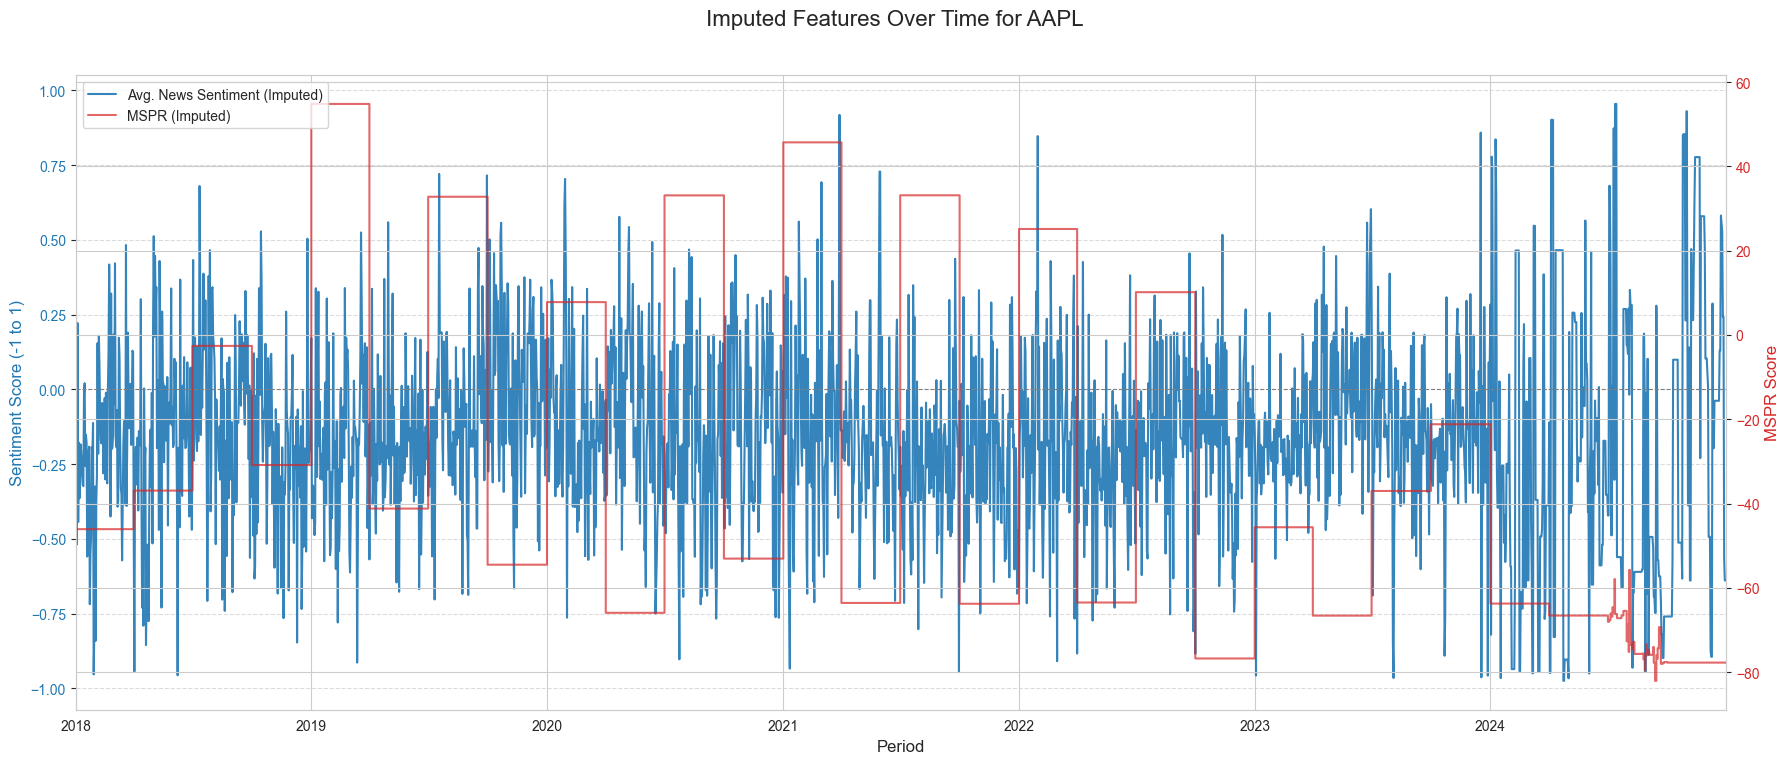


--- Visual Verification for NVDA ---


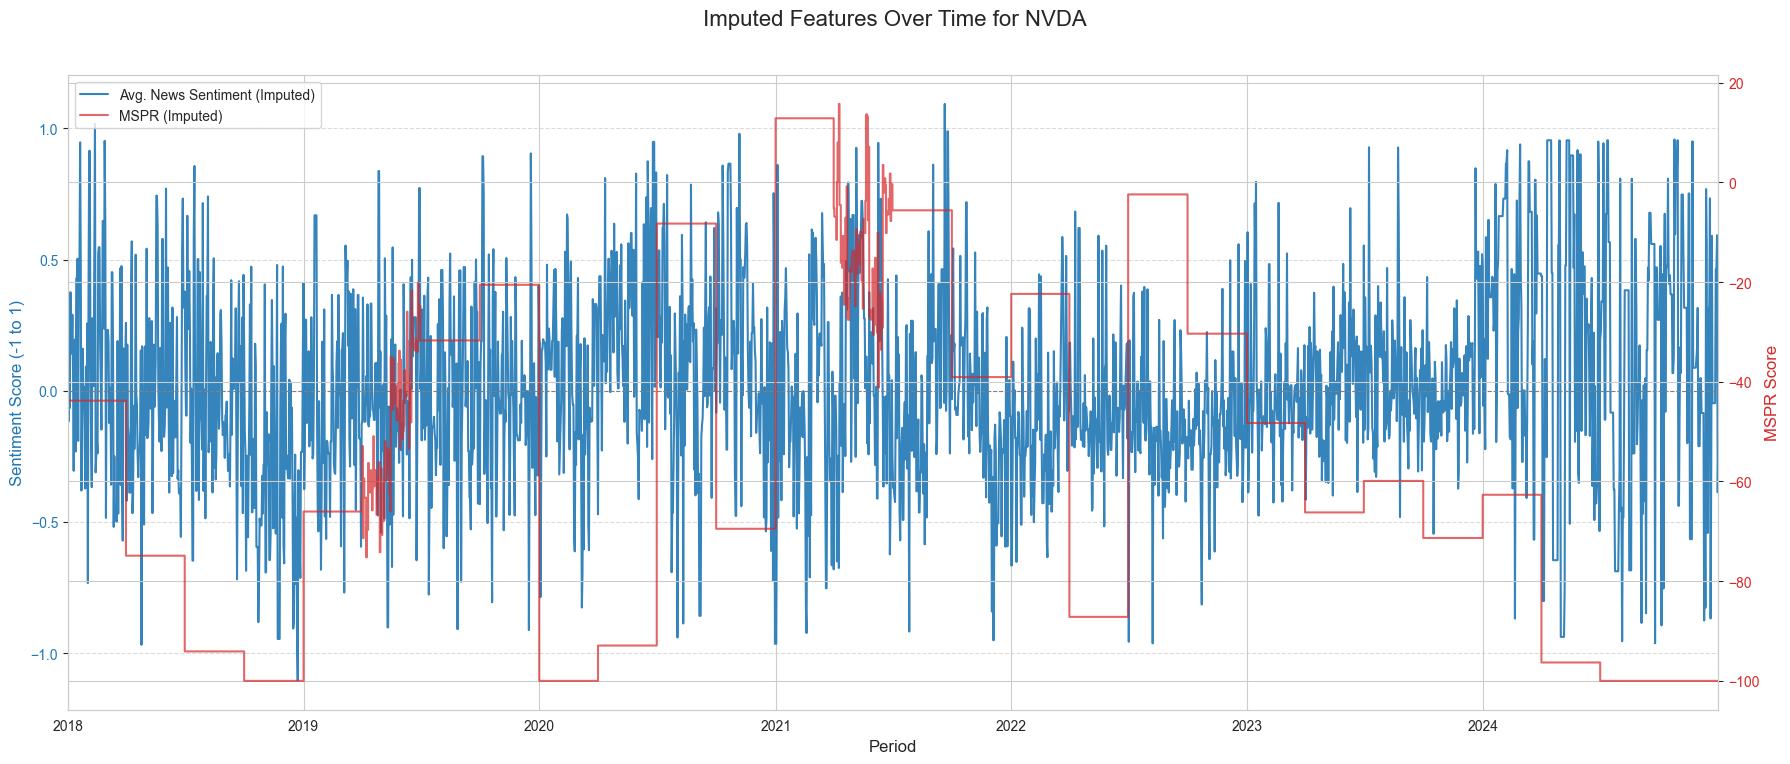


--- Visual Verification for GOOGL ---


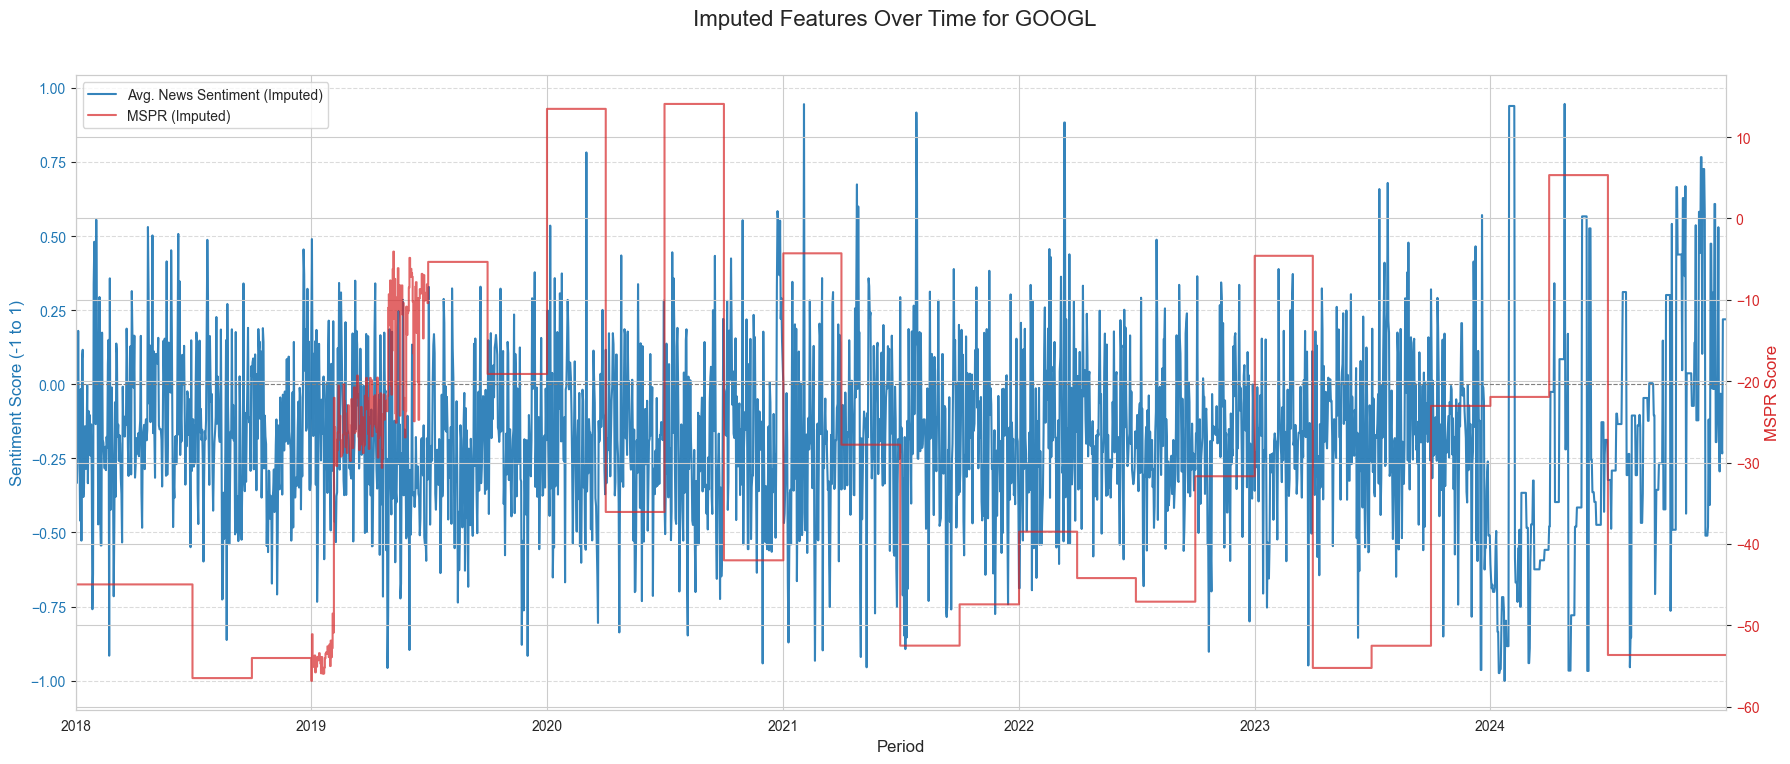


Visual verification complete.


In [38]:
# 1.2.6: Visual Verification of Imputed Features
print("1.2.6: Plotting imputed features to visually verify the results")
print("="*60)

if not company_dfs_final:
    print("Final dataframes not found. Please ensure the main imputation cell has completed.")
else:
    for ticker, df_original in company_dfs_final.items():
        print(f"\n--- Visual Verification for {ticker.upper()} ---")
        
        # --- FIX: Ensure the dataframe has a proper DatetimeIndex before plotting ---
        df = df_original.copy()
        if 'Period' in df.columns:
            df['Period'] = pd.to_datetime(df['Period'])
            df = df.set_index('Period')
        # --------------------------------------------------------------------------
            
        fig, ax1 = plt.subplots(figsize=(18, 8))
        fig.suptitle(f'Imputed Features Over Time for {ticker.upper()}', fontsize=16)

        # Plot 1: average_news_sentiment on the primary y-axis
        color1 = 'tab:blue'
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Sentiment Score (-1 to 1)', color=color1)
        # Use the pandas plotting API which correctly handles the DatetimeIndex
        df['average_news_sentiment'].plot(ax=ax1, label='Avg. News Sentiment (Imputed)', color=color1, alpha=0.9)
        ax1.tick_params(axis='y', labelcolor=color1)
        ax1.grid(True, axis='y', linestyle='--', alpha=0.7)
        ax1.axhline(0, color='grey', linestyle='--', linewidth=0.8)

        # Create a second y-axis that shares the same x-axis
        ax2 = ax1.twinx()
        
        # Plot 2: mspr on the secondary y-axis
        color2 = 'tab:red'
        ax2.set_ylabel('MSPR Score', color=color2)
        df['mspr'].plot(ax=ax2, label='MSPR (Imputed)', color=color2, alpha=0.7, drawstyle='steps-post')
        ax2.tick_params(axis='y', labelcolor=color2)
        
        # Add legends
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

        # Matplotlib's date formatter will now work correctly with the DatetimeIndex
        locator = mdates.AutoDateLocator()
        formatter = mdates.ConciseDateFormatter(locator)
        plt.gca().xaxis.set_major_locator(locator)
        plt.gca().xaxis.set_major_formatter(formatter)
        
        fig.tight_layout(rect=[0, 0.03, 1, 0.96])
        plt.show()

print("\nVisual verification complete.")

### 1.3: Inspecting the `Stockprices` Dataset

This sub-phase focuses on understanding the raw `Stockprices.csv` file. Our initial inspection in cell 1.2 revealed several data quality issues that must be addressed before analysis:

1.  **Data Types**: All price and volume columns are stored as strings, not numeric types. They contain currency symbols (`$`) and use both `.` and `,` as separators, which will cause parsing errors.
2.  **Column Structure**: The data for all three companies is in a wide format in a single file. For easier analysis, we need to split this into three separate, standardized dataframes.
3.  **Redundant Date Columns**: The file contains a `DATE` column (for NVDA and GOOGL) and a `date APPLE` column. These need to be unified into a single `Period` column for consistency with our other datasets.
4.  **Missing Data**: We must check for missing dates and any `NaN` or zero values after the initial cleaning.

In [21]:
# 1.3.0: Inspecting the Stock Prices Dataset
print("1.3.0: Full inspection of the Stock Prices Dataset")
print("-"*30)

# --- 1. Define a robust cleaning function ---
def clean_price_data(value):
    """
    Converts a string price/volume into a numeric float.
    Handles '$', ',', and '.' as separators.
    """
    if isinstance(value, str):
        # Remove currency symbols and spaces, then replace ',' with '.'
        # This standardizes all values to use '.' as the decimal separator.
        value = value.replace('$', '').replace('.', '').replace(',', '.').strip()
    
    # Convert to numeric, coercing errors to NaN (Not a Number)
    return pd.to_numeric(value, errors='coerce')

# --- 2. Perform a preliminary cleaning on a copy for inspection purposes ---
stocks_df_inspect = stocks_df_raw.copy()
for col in stocks_df_inspect.columns:
    if 'DATE' not in col.upper(): # Don't try to convert date columns
        stocks_df_inspect[col] = stocks_df_inspect[col].apply(clean_price_data)

print("--- Data Quality Report (after preliminary cleaning) ---\n")

# --- 3. Check for Null/NaN Values ---
print("1. NaN values per column:")
print(stocks_df_inspect.isna().sum())

# --- 4. Check for Zero Values ---
print("\n2. Zero values per column:")
print((stocks_df_inspect == 0).sum())

# --- 5. Check for Missing Dates ---
print("\n3. Date range integrity:")
expected_dates = pd.to_datetime(pd.date_range(start='2018-01-01', end='2024-12-31'))
for date_col in ['DATE', 'date APPLE']:
    print(f"\n--- Checking '{date_col}' column ---")
    actual_dates = pd.to_datetime(stocks_df_inspect[date_col], errors='coerce').dropna()
    missing_dates = expected_dates.difference(actual_dates)
    
    if len(missing_dates) == 0:
        print(f"Success: All {len(expected_dates)} days from 2018 to 2024 seem to be present.")
    else:
        # Weekends and holidays are expected to be missing from raw trading data
        print(f"Found {len(missing_dates)} missing dates (this is expected and will be handled by reindexing).")
        print(f"   Example missing dates: {missing_dates[:3].strftime('%Y-%m-%d').to_list()}")

print("\n" + "-"*30)
print("Inspection complete.")

1.3.0: Full inspection of the Stock Prices Dataset
------------------------------
--- Data Quality Report (after preliminary cleaning) ---

1. NaN values per column:
DATE             0
open NVIDIA      0
high NVIDIA      0
low NVIDIA       0
close NVIDIA     0
volume NVIDIA    0
open GOOGLE      0
high GOOGLE      0
low GOOGLE       0
close GOOGLE     0
volume GOOGLE    0
date APPLE       0
open APPLE       0
high APPLE       0
low APPLE        0
close APPLE      0
volume APPLE     0
dtype: int64

2. Zero values per column:
DATE             0
open NVIDIA      0
high NVIDIA      0
low NVIDIA       0
close NVIDIA     0
volume NVIDIA    0
open GOOGLE      0
high GOOGLE      0
low GOOGLE       0
close GOOGLE     0
volume GOOGLE    0
date APPLE       0
open APPLE       0
high APPLE       0
low APPLE        0
close APPLE      0
volume APPLE     0
dtype: int64

3. Date range integrity:

--- Checking 'DATE' column ---
Found 796 missing dates (this is expected and will be handled by reindexing)

### 1.4: Cleaning the `Stockprices` Dataset



Based on the inspection, the primary missing data consists of non-trading days (weekends and holidays). For financial time-series data like stock prices, the methodologically correct approach is **forward-filling**.

**Strategy:**

*   **OHLCV Columns (Open, High, Low, Close, Volume):** We will use forward-fill (`ffill`) to propagate the last known trading day's values across the non-trading gaps. This correctly assumes that the closing price of Friday is the operative price until the market opens again on Monday.
*   We do **not** use `IterativeImputer` here. Unlike sentiment features which may have complex inter-dependencies, stock prices follow a pattern (a random walk) where predicting a missing day based on other features is not methodologically sound. `ffill` is the industry standard.

In [22]:
# 1.4.0: Splitting and Standardizing the Stock Prices DataFrame
print("1.4.0: Splitting and Standardizing the Stock Prices DataFrame")
print("-"*30)

# The cleaning function is defined here as it is used in this step.
def clean_price_data(value):
    if isinstance(value, str):
        value = value.replace('$', '').replace('.', '').replace(',', '.').strip()
    return pd.to_numeric(value, errors='coerce')

# --- 1. Define column mappings and create a dictionary to hold the results ---
col_map = {
    'NVDA': {
        'date_col': 'DATE',
        'cols': ['open NVIDIA', 'high NVIDIA', 'low NVIDIA', 'close NVIDIA', 'volume NVIDIA']
    },
    'GOOGL': {
        'date_col': 'DATE',
        'cols': ['open GOOGLE', 'high GOOGLE', 'low GOOGLE', 'close GOOGLE', 'volume GOOGLE']
    },
    'AAPL': {
        'date_col': 'date APPLE',
        'cols': ['open APPLE', 'high APPLE', 'low APPLE', 'close APPLE', 'volume APPLE']
    }
}
standard_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
stock_dfs_cleaned = {}

# --- 2. Loop, Split, Clean, and Standardize ---
for ticker, mapping in col_map.items():
    print(f"--- Processing {ticker} ---")
    
    date_col = mapping['date_col']
    ticker_cols = [date_col] + mapping['cols']
    df_ticker = stocks_df_raw[ticker_cols].copy()
    
    df_ticker.columns = ['Period'] + standard_cols
    
    for col in standard_cols:
        df_ticker[col] = df_ticker[col].apply(clean_price_data)
        
    df_ticker['Period'] = pd.to_datetime(df_ticker['Period'])
    df_ticker = df_ticker.set_index('Period')
    
    stock_dfs_cleaned[ticker] = df_ticker
    print(f"Successfully created and cleaned dataframe for {ticker}.")

print("\n" + "-"*30)
print("All stock dataframes have been split and standardized.")
print("\n--- Sample of cleaned NVDA stock data ---")
display(stock_dfs_cleaned['NVDA'].head())

1.4.0: Splitting and Standardizing the Stock Prices DataFrame
------------------------------
--- Processing NVDA ---
Successfully created and cleaned dataframe for NVDA.
--- Processing GOOGL ---
Successfully created and cleaned dataframe for GOOGL.
--- Processing AAPL ---
Successfully created and cleaned dataframe for AAPL.

------------------------------
All stock dataframes have been split and standardized.

--- Sample of cleaned NVDA stock data ---


,Open,High,Low,Close,Volume
Period,,,,,
2018-01-02,4.84,4.93,4.81,4.93,8793106.0
2018-01-03,5.05,5.28,5.04,5.25,22617248.0
2018-01-04,5.34,5.39,5.26,5.28,14422105.0
2018-01-05,5.30,5.36,5.22,5.33,14344198.0
2018-01-08,5.45,5.56,5.40,5.49,21789078.0


In [44]:
# 1.4.1: Aligning, Imputing, and Verifying Final Stock Dataframes
print("1.4.1: Aligning, Imputing, and Verifying Final Stock Dataframes")
print("-"*30)

# --- 1. Define the master date range ---
expected_dates = pd.to_datetime(pd.date_range(start='2018-01-01', end='2024-12-31'))
stock_dfs_final = {}

# --- 2. Loop, Re-index, and Impute ---
for ticker, df in stock_dfs_cleaned.items():
    print(f"--- Processing {ticker} ---")
    
    # Align to the master date range, which creates NaNs
    df_aligned = df.reindex(expected_dates)
    
    # Impute NaNs using the defined strategy
    df_imputed = df_aligned.ffill().bfill()
    
    # --- FIX: Reset the index so 'Period' becomes a column ---
    # This makes its structure identical to the company_dfs_final dataframes.
    df_imputed = df_imputed.reset_index().rename(columns={'index': 'Period'})
    
    stock_dfs_final[ticker] = df_imputed
    print(f"Successfully aligned and imputed dataframe for {ticker}.")
    
# --- 3. Final Verification ---
print("\n" + "-"*30)
print("Final verification of imputed stock dataframes:")
for ticker, df in stock_dfs_final.items():
    print(f"\n--- Verification for {ticker} ---")
    nan_count = df.isna().sum().sum()
    if nan_count == 0:
        print("Success: No NaN values found.")
        display(df.head(3))
    else:
        print(f"Warning: Found {nan_count} remaining NaN values.")

print("\nStock data cleaning and preparation complete.")

1.4.1: Aligning, Imputing, and Verifying Final Stock Dataframes
------------------------------
--- Processing NVDA ---
Successfully aligned and imputed dataframe for NVDA.
--- Processing GOOGL ---
Successfully aligned and imputed dataframe for GOOGL.
--- Processing AAPL ---
Successfully aligned and imputed dataframe for AAPL.

------------------------------
Final verification of imputed stock dataframes:

--- Verification for NVDA ---
Success: No NaN values found.


,Period,Open,High,Low,Close,Volume
0,2018-01-01,4.84,4.93,4.81,4.93,8793106.0
1,2018-01-02,4.84,4.93,4.81,4.93,8793106.0
2,2018-01-03,5.05,5.28,5.04,5.25,22617248.0



--- Verification for GOOGL ---
Success: No NaN values found.


,Period,Open,High,Low,Close,Volume
0,2018-01-01,52.29,53.43,52.29,53.29,1577388.0
1,2018-01-02,52.29,53.43,52.29,53.29,1577388.0
2,2018-01-03,53.33,54.43,53.30,54.20,1555220.0



--- Verification for AAPL ---
Success: No NaN values found.


,Period,Open,High,Low,Close,Volume
0,2018-01-01,39.89,40.39,39.68,40.38,23963144.0
1,2018-01-02,39.89,40.39,39.68,40.38,23963144.0
2,2018-01-03,40.44,40.92,40.31,40.37,27678237.0



Stock data cleaning and preparation complete.


## Phase 2: EDA

### 2.1: EDA on AAPL Dataset

#### 2.1.a: Univariate Analysis

In [27]:
# 2.1.a.0: Setting up plotting style
print("2.1.a.0: Setting up plotting style")
print("-"*30)
# Set a consistent and professional style for all upcoming plots
sns.set_style("whitegrid")
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12

print("Plotting style configured.")

2.1.a.0: Setting up plotting style
------------------------------
Plotting style configured.


2.1.a.1: Univariate Analysis of Key Features for AAPL
------------------------------

--- Analysis for 'average_news_sentiment' ---


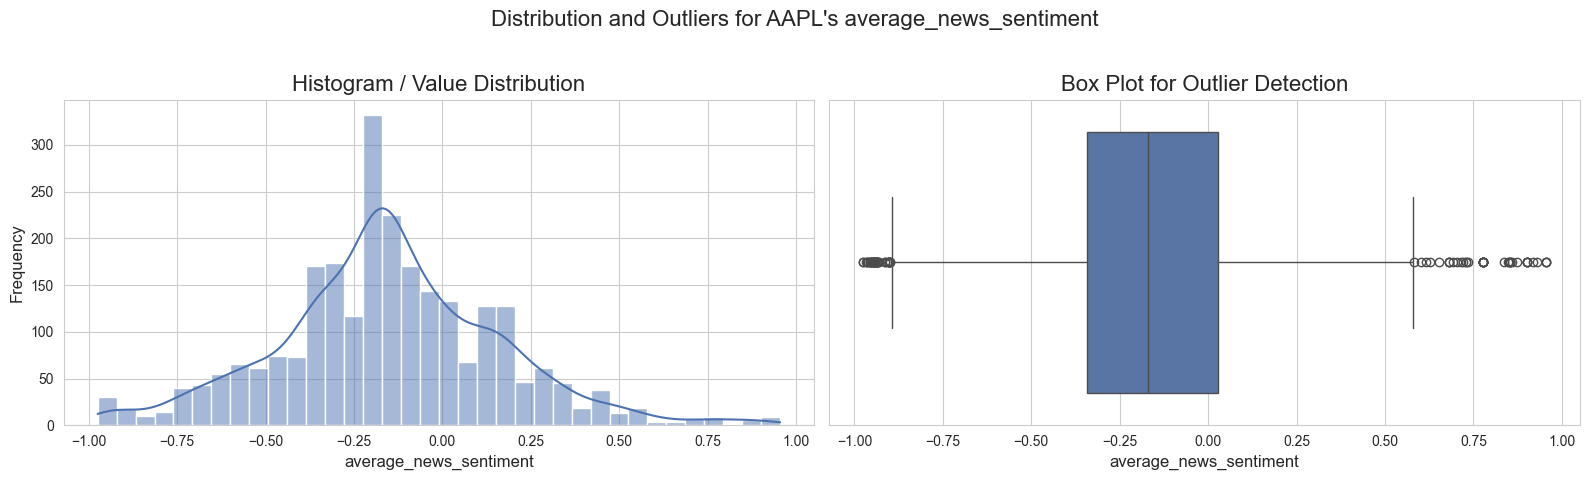


Descriptive Statistics for average_news_sentiment:


count    2557.000000
mean       -0.152150
std         0.316323
min        -0.974562
25%        -0.341525
50%        -0.170285
75%         0.027260
max         0.954711
Name: average_news_sentiment, dtype: float64


------------------------------

--- Analysis for 'market_average_sentiment' ---


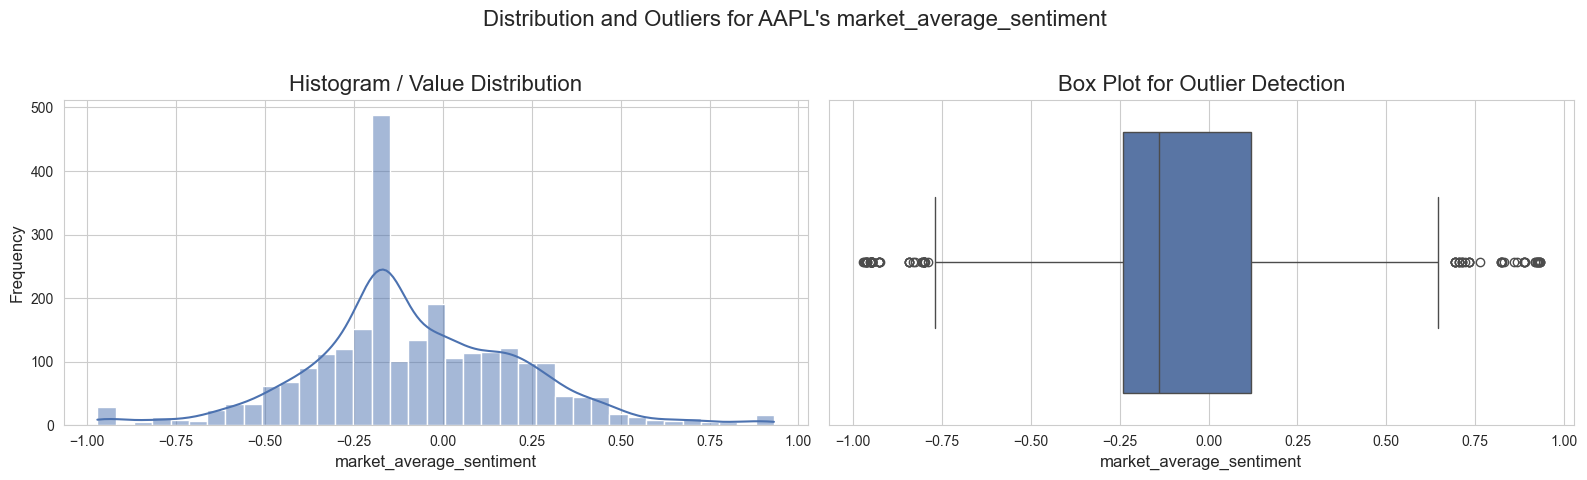


Descriptive Statistics for market_average_sentiment:


count    2557.000000
mean       -0.077661
std         0.301185
min        -0.971553
25%        -0.241212
50%        -0.140429
75%         0.119536
max         0.931169
Name: market_average_sentiment, dtype: float64


------------------------------

--- Analysis for 'mspr' ---


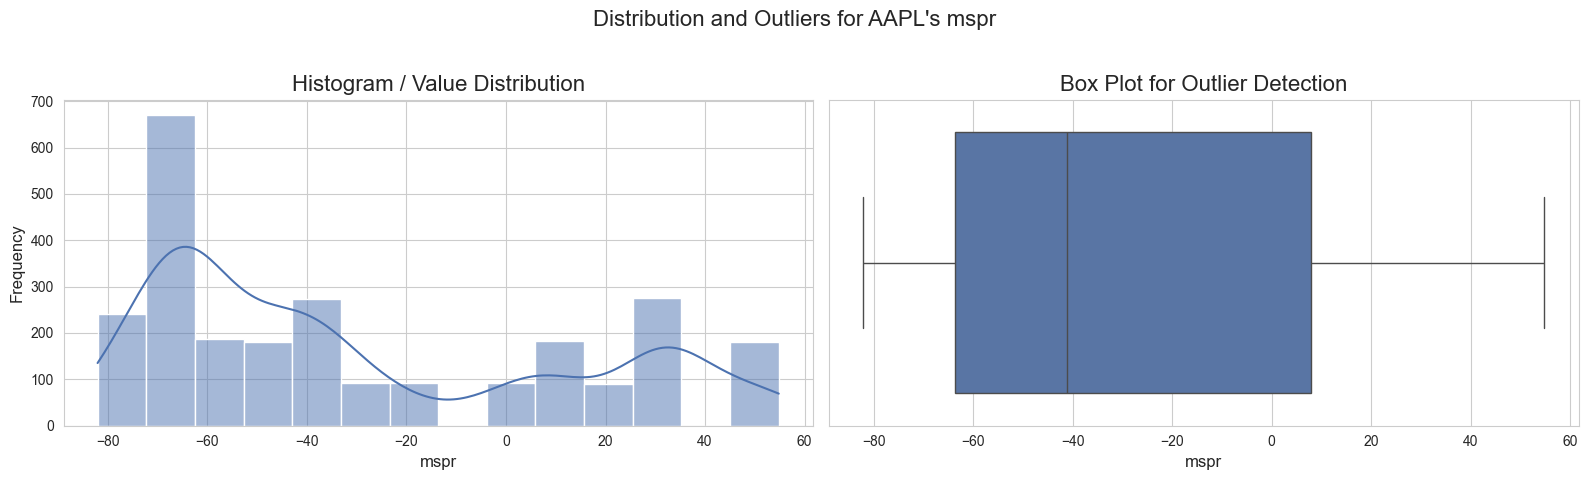


Descriptive Statistics for mspr:


count    2557.000000
mean      -28.881771
std        41.526017
min       -82.083183
25%       -63.737488
50%       -41.198193
75%         7.795030
max        54.820750
Name: mspr, dtype: float64


------------------------------

--- Analysis for 'article_volume' ---


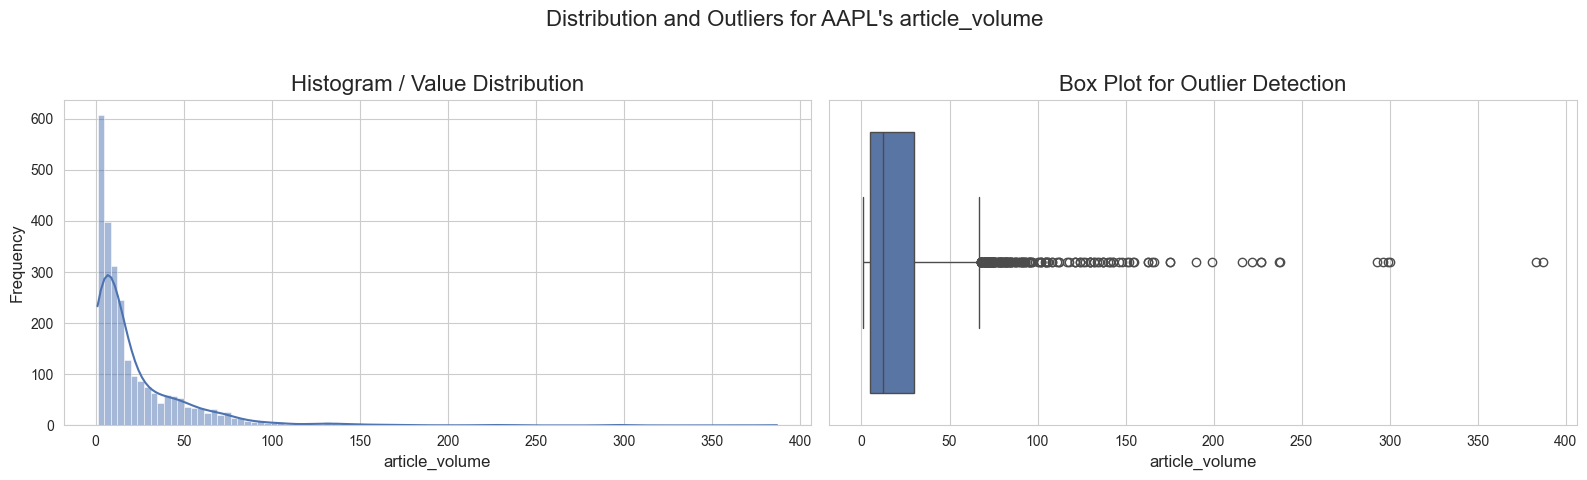


Descriptive Statistics for article_volume:


count    2557.000000
mean       23.141963
std        31.909040
min         1.000000
25%         5.000000
50%        12.000000
75%        30.000000
max       387.000000
Name: article_volume, dtype: float64


------------------------------

--- Analysis for '10-K_sentiment' ---


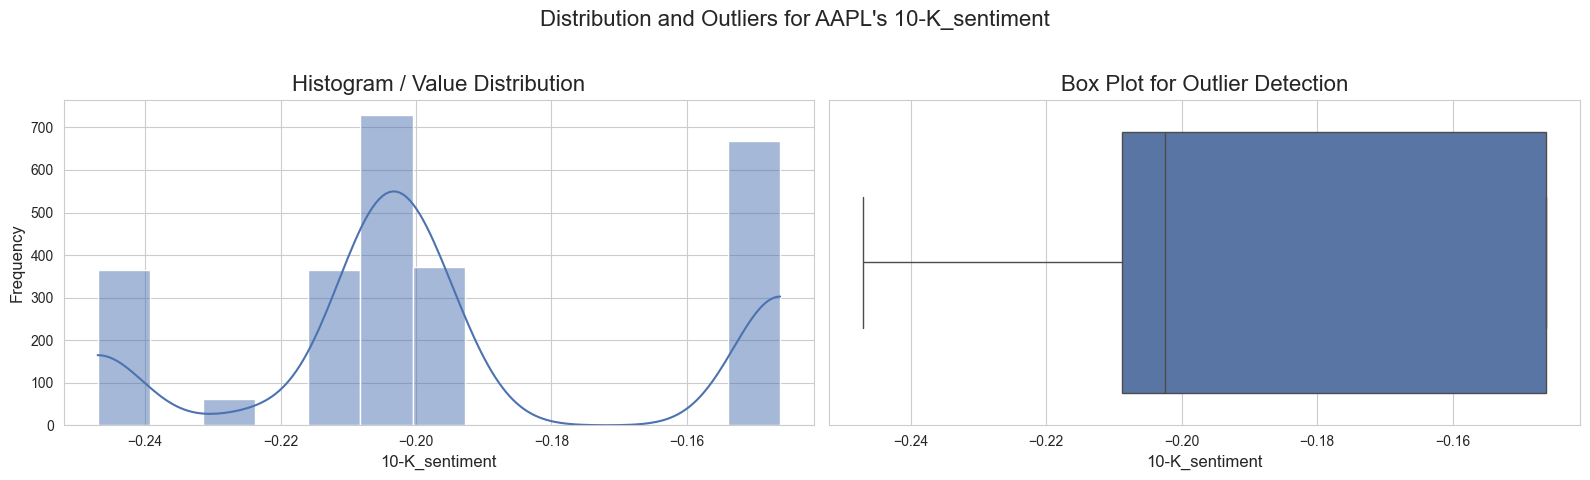


Descriptive Statistics for 10-K_sentiment:


count    2557.000000
mean       -0.194917
std         0.032778
min        -0.247011
25%        -0.208749
50%        -0.202405
75%        -0.146227
max        -0.146227
Name: 10-K_sentiment, dtype: float64


------------------------------

--- Analysis for '10-Q_sentiment' ---


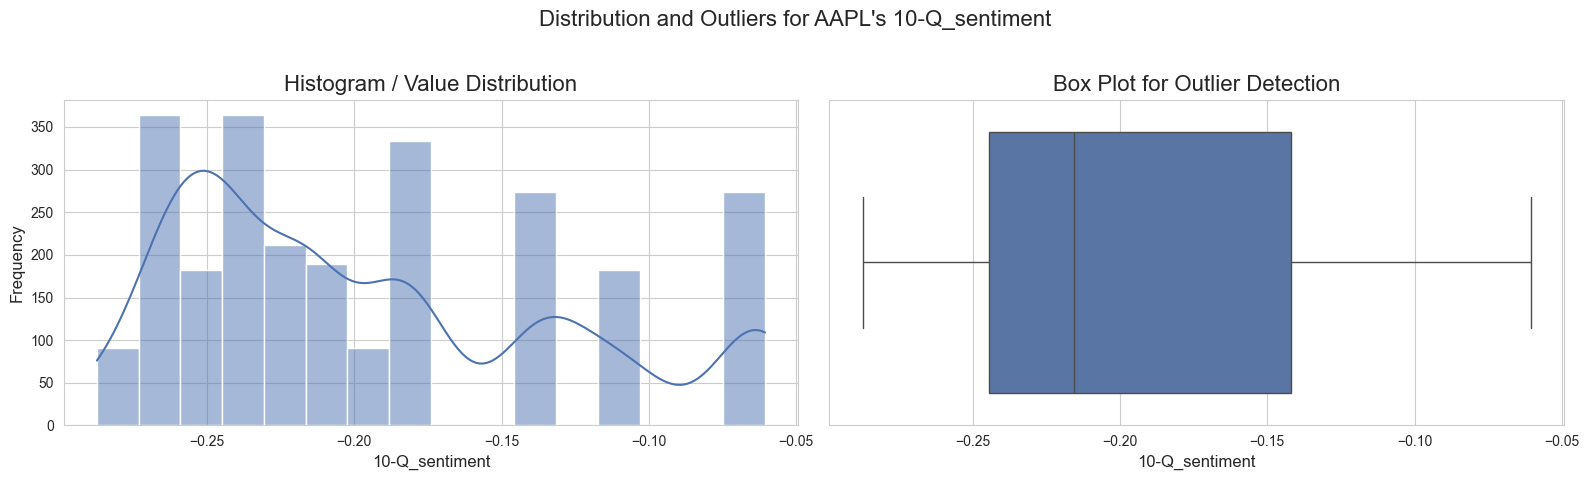


Descriptive Statistics for 10-Q_sentiment:


count    2557.000000
mean       -0.193874
std         0.066043
min        -0.287310
25%        -0.244432
50%        -0.215684
75%        -0.141893
max        -0.060567
Name: 10-Q_sentiment, dtype: float64


------------------------------


In [45]:
# 2.1.a.1: Univariate Analysis of Key Features for AAPL
print("2.1.a.1: Univariate Analysis of Key Features for AAPL")
print("-"*30)

# Select the final, imputed dataframe for AAPL
aapl_df = company_dfs_final.get('AAPL')

if aapl_df is not None:
    # Define the key features for univariate analysis
    features_to_analyze = [
        'average_news_sentiment',
        'market_average_sentiment',
        'mspr',
        'article_volume',
        '10-K_sentiment',
        '10-Q_sentiment'
    ]

    # Generate plots and stats for each feature
    for feature in features_to_analyze:
        print(f"\n--- Analysis for '{feature}' ---")
        
        # Create a figure with two subplots: histogram and boxplot
        fig, axes = plt.subplots(1, 2, figsize=(16, 5))
        fig.suptitle(f"Distribution and Outliers for AAPL's {feature}", fontsize=16)
        
        # Histogram
        sns.histplot(aapl_df[feature], kde=True, ax=axes[0])
        axes[0].set_title('Histogram / Value Distribution')
        axes[0].set_xlabel(feature)
        axes[0].set_ylabel('Frequency')
        
        # Box Plot
        sns.boxplot(x=aapl_df[feature], ax=axes[1])
        axes[1].set_title('Box Plot for Outlier Detection')
        axes[1].set_xlabel(feature)
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
        
        # Descriptive Statistics
        print(f"\nDescriptive Statistics for {feature}:")
        display(aapl_df[feature].describe())
        print("\n" + "-"*30)

else:
    print("Error: Final imputed dataframe for AAPL not found.")

#### 2.1.b: Bivariate Time-Series Analysis

In [46]:
# 2.1.b.0: Bivariate Time-Series Analysis for AAPL
print("2.1.b.0: Merging Sentiment and Stock Data for AAPL")
print("-"*30)

# Retrieve the final imputed dataframes
aapl_sentiment_df = company_dfs_final.get('AAPL')
aapl_stock_df = stock_dfs_final.get('AAPL')

if aapl_sentiment_df is not None and aapl_stock_df is not None:
    # --- FIX: Simplified merge on the 'Period' column ---
    # Since both dataframes now have an identical 'Period' column, the merge is clean.
    aapl_eda_df = pd.merge(
        aapl_sentiment_df,
        aapl_stock_df,
        on='Period',
        how='outer'
    )
    
    # Set the 'Period' column as the DatetimeIndex for plotting
    aapl_eda_df['Period'] = pd.to_datetime(aapl_eda_df['Period'])
    aapl_eda_df = aapl_eda_df.set_index('Period')
    
    # Calculate daily return for volatility analysis
    aapl_eda_df['daily_return'] = aapl_eda_df['Close'].pct_change() * 100 # In percentage
    
    print("AAPL sentiment and stock data merged and correctly indexed for EDA.")
    print("New 'daily_return' column created.")
    display(aapl_eda_df.head())
else:
    print("Error: Could not merge dataframes. One or both of the final imputed dataframes for AAPL are missing.")

2.1.b.0: Merging Sentiment and Stock Data for AAPL
------------------------------
AAPL sentiment and stock data merged and correctly indexed for EDA.
New 'daily_return' column created.


,article_volume,average_news_sentiment,AVG_AAPL_Density,AVG_NVDA_Density,AVG_GOOGL_Density,market_average_sentiment,10-K_sentiment,10-Q_sentiment,8-K_sentiment,mspr,Open,High,Low,Close,Volume,daily_return
Period,,,,,,,,,,,,,,,,
2018-01-01,8.0,-0.017894,0.068807,0.0125,0.0,0.311223,-0.146227,-0.217508,-0.023673,-46.079872,39.89,40.39,39.68,40.38,23963144.0,NaN
2018-01-02,51.0,-0.127239,0.166147,0.0000,0.0,0.311223,-0.146227,-0.217508,-0.023673,-46.079872,39.89,40.39,39.68,40.38,23963144.0,0.000000
2018-01-03,62.0,-0.518287,0.124039,0.0000,0.0,-0.018505,-0.146227,-0.217508,-0.023673,-46.079872,40.44,40.92,40.31,40.37,27678237.0,-0.024765
2018-01-04,53.0,0.222064,0.148336,0.0000,0.0,-0.018505,-0.146227,-0.217508,-0.023673,-46.079872,40.45,40.66,40.34,40.56,21036376.0,0.470647
2018-01-05,104.0,-0.443398,0.173987,0.0000,0.0,0.071511,-0.146227,-0.217508,-0.023673,-46.079872,40.66,41.11,40.57,41.02,22185401.0,1.134122


2.1.b.1: Plotting Core Sentiment vs. Price for AAPL
------------------------------


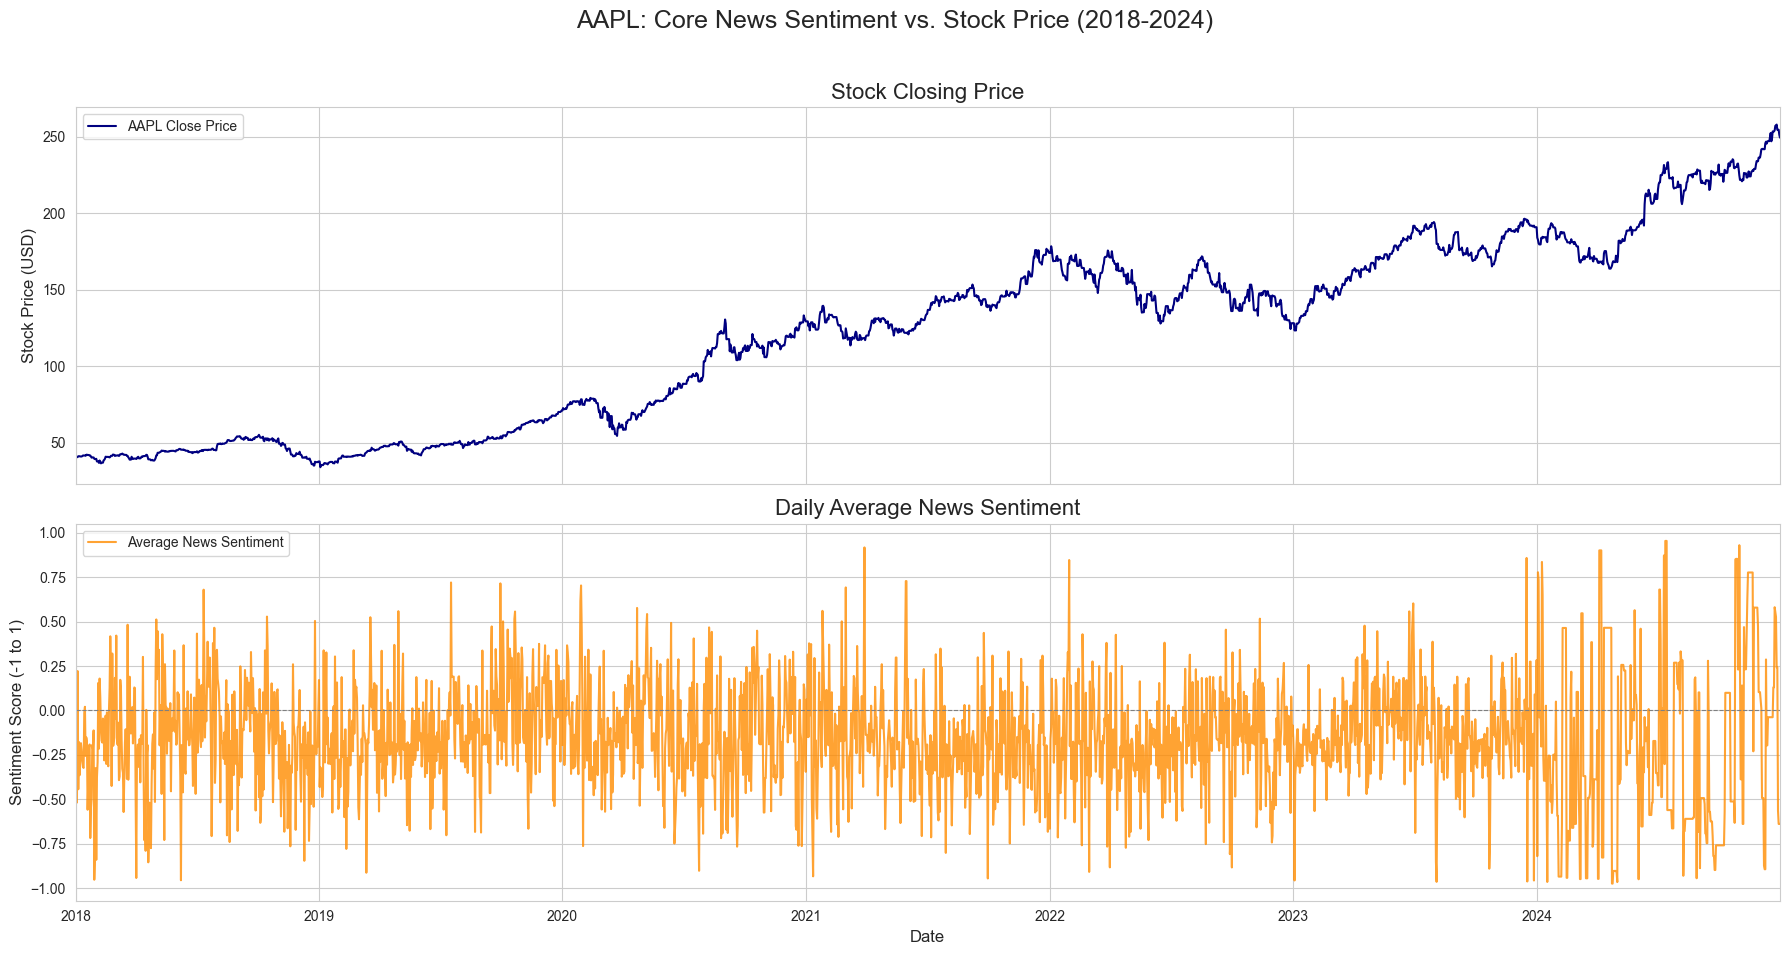

In [47]:
# 2.1.b.1: Core Sentiment vs. Price
print("2.1.b.1: Plotting Core Sentiment vs. Price for AAPL")
print("-"*30)
import matplotlib.dates as mdates

fig, axes = plt.subplots(2, 1, figsize=(18, 10), sharex=True)
fig.suptitle('AAPL: Core News Sentiment vs. Stock Price (2018-2024)', fontsize=18)

# No changes needed here, as aapl_eda_df now has the correct index.
# The pandas plotting API will correctly interpret the DatetimeIndex.

# Plot 1: Close Price
aapl_eda_df['Close'].plot(ax=axes[0], label='AAPL Close Price', color='navy')
axes[0].set_ylabel('Stock Price (USD)')
axes[0].set_title('Stock Closing Price')
axes[0].legend()
axes[0].grid(True)

# Plot 2: Average News Sentiment
aapl_eda_df['average_news_sentiment'].plot(ax=axes[1], label='Average News Sentiment', color='darkorange', alpha=0.8)
axes[1].set_ylabel('Sentiment Score (-1 to 1)')
axes[1].set_title('Daily Average News Sentiment')
axes[1].axhline(0, color='grey', linestyle='--', linewidth=0.8)
axes[1].legend()
axes[1].grid(True)

# Improve date formatting on the x-axis for readability
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
axes[1].xaxis.set_major_locator(locator)
axes[1].xaxis.set_major_formatter(formatter)

plt.xlabel('Date')
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

2.1.b.2: Plotting Attention vs. Price & Volatility for AAPL
------------------------------


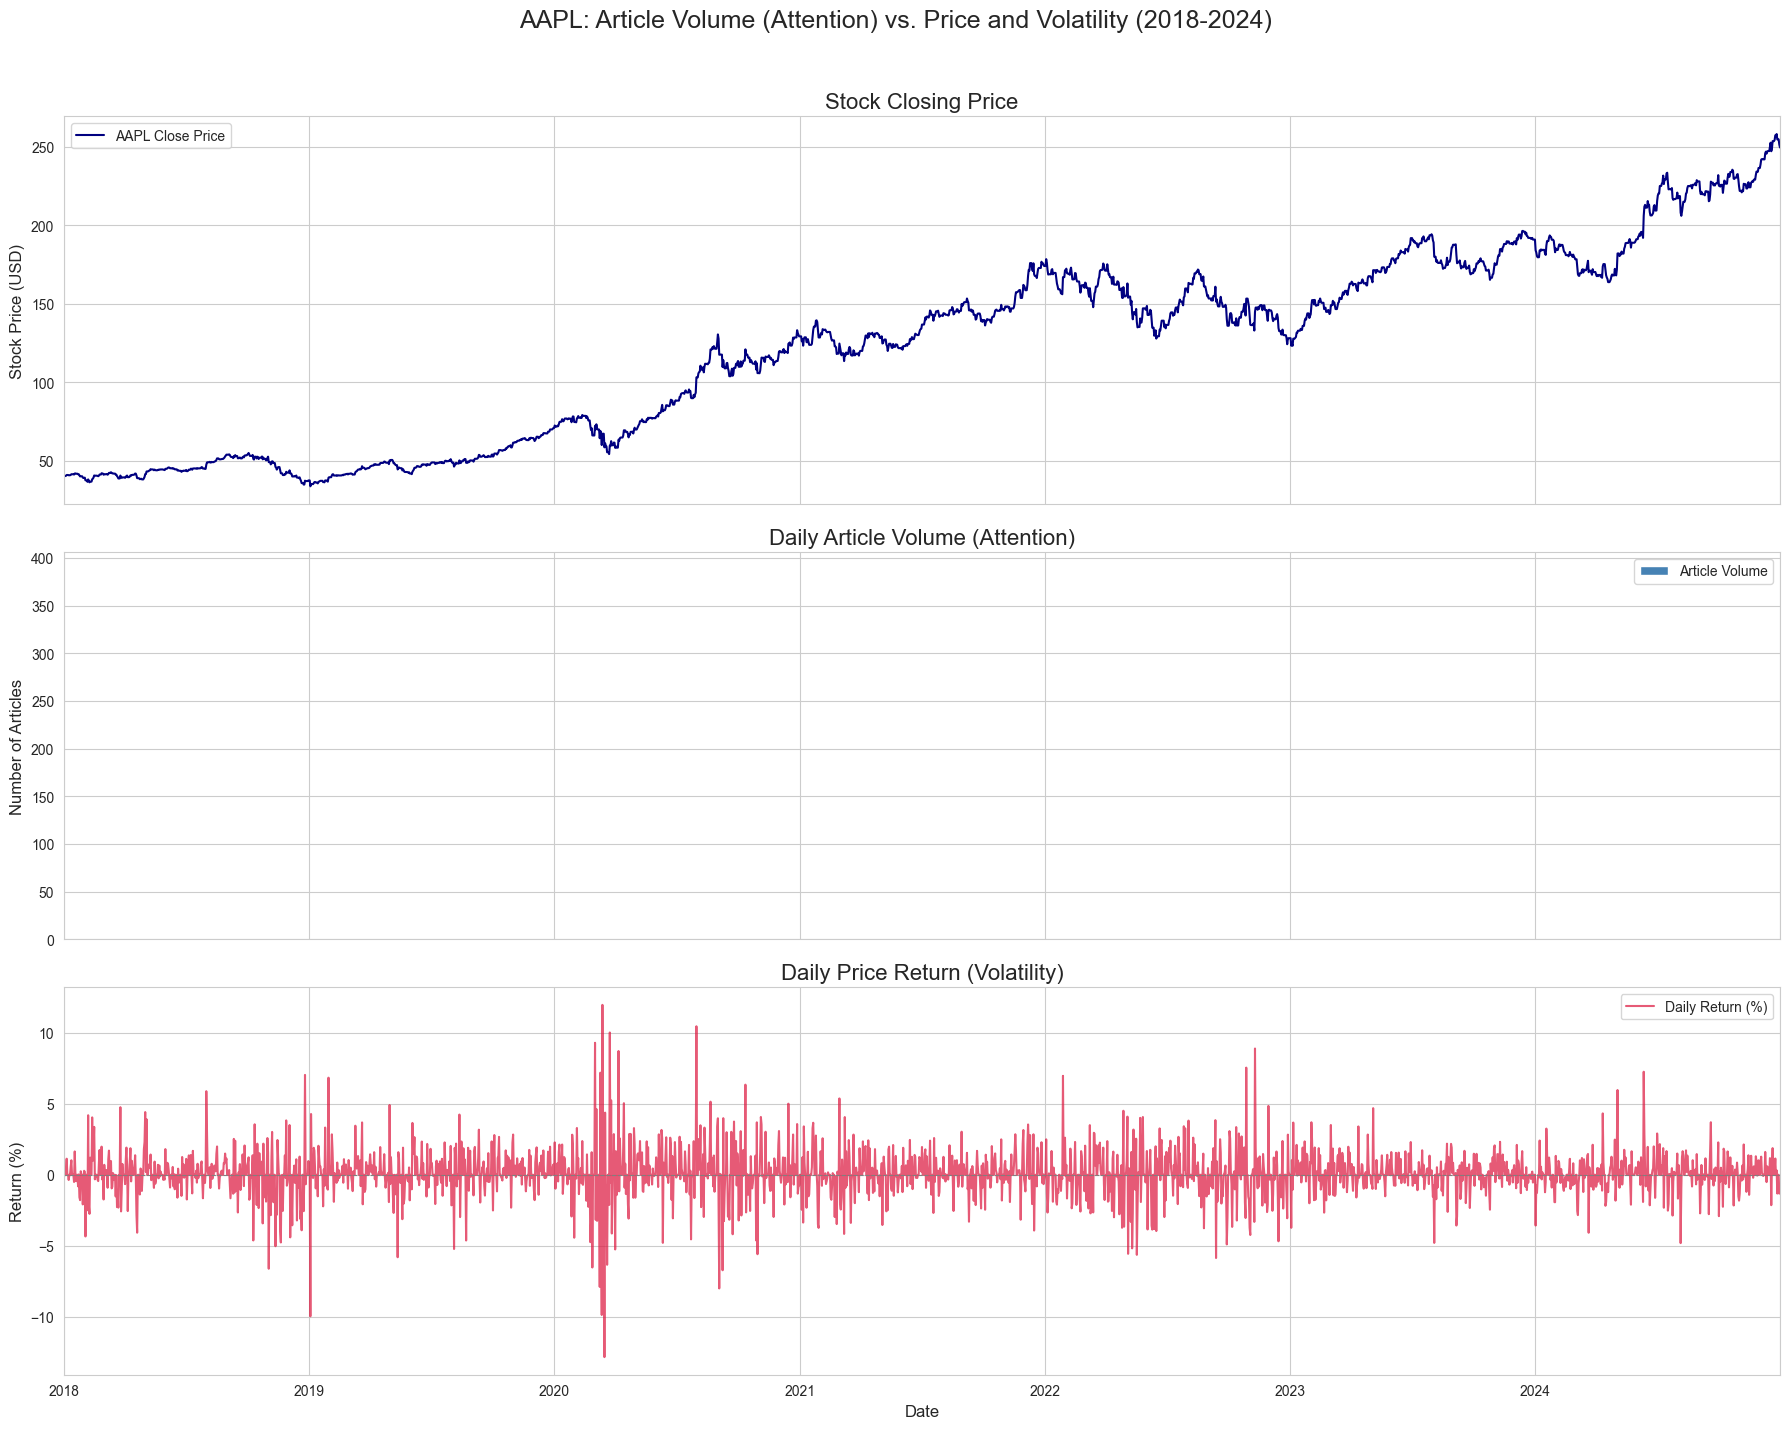

In [48]:
# 2.1.b.2: Attention vs. Price & Volatility
print("2.1.b.2: Plotting Attention vs. Price & Volatility for AAPL")
print("-"*30)

fig, axes = plt.subplots(3, 1, figsize=(18, 15), sharex=True)
fig.suptitle('AAPL: Article Volume (Attention) vs. Price and Volatility (2018-2024)', fontsize=18)

# --- FIX: Use the robust pandas plotting API ---
# Plot 1: Close Price
aapl_eda_df['Close'].plot(ax=axes[0], label='AAPL Close Price', color='navy')
axes[0].set_ylabel('Stock Price (USD)')
axes[0].set_title('Stock Closing Price')
axes[0].legend()
axes[0].grid(True)

# Plot 2: Article Volume (using .bar())
aapl_eda_df['article_volume'].plot(kind='bar', ax=axes[1], label='Article Volume', color='steelblue', width=2.0)
# Improve x-axis readability for bar charts
axes[1].xaxis.set_major_locator(plt.MaxNLocator(10)) # Show fewer date ticks
axes[1].set_ylabel('Number of Articles')
axes[1].set_title('Daily Article Volume (Attention)')
axes[1].legend()
axes[1].grid(True, axis='y') # Grid on y-axis only for bar chart

# Plot 3: Daily Return (Volatility)
aapl_eda_df['daily_return'].plot(ax=axes[2], label='Daily Return (%)', color='crimson', alpha=0.7)
axes[2].set_ylabel('Return (%)')
axes[2].set_title('Daily Price Return (Volatility)')
axes[2].axhline(0, color='grey', linestyle='--', linewidth=0.8)
axes[2].legend()
axes[2].grid(True)

plt.xlabel('Date')
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

2.1.b.3: Plotting Insider vs. Public Sentiment for AAPL
------------------------------


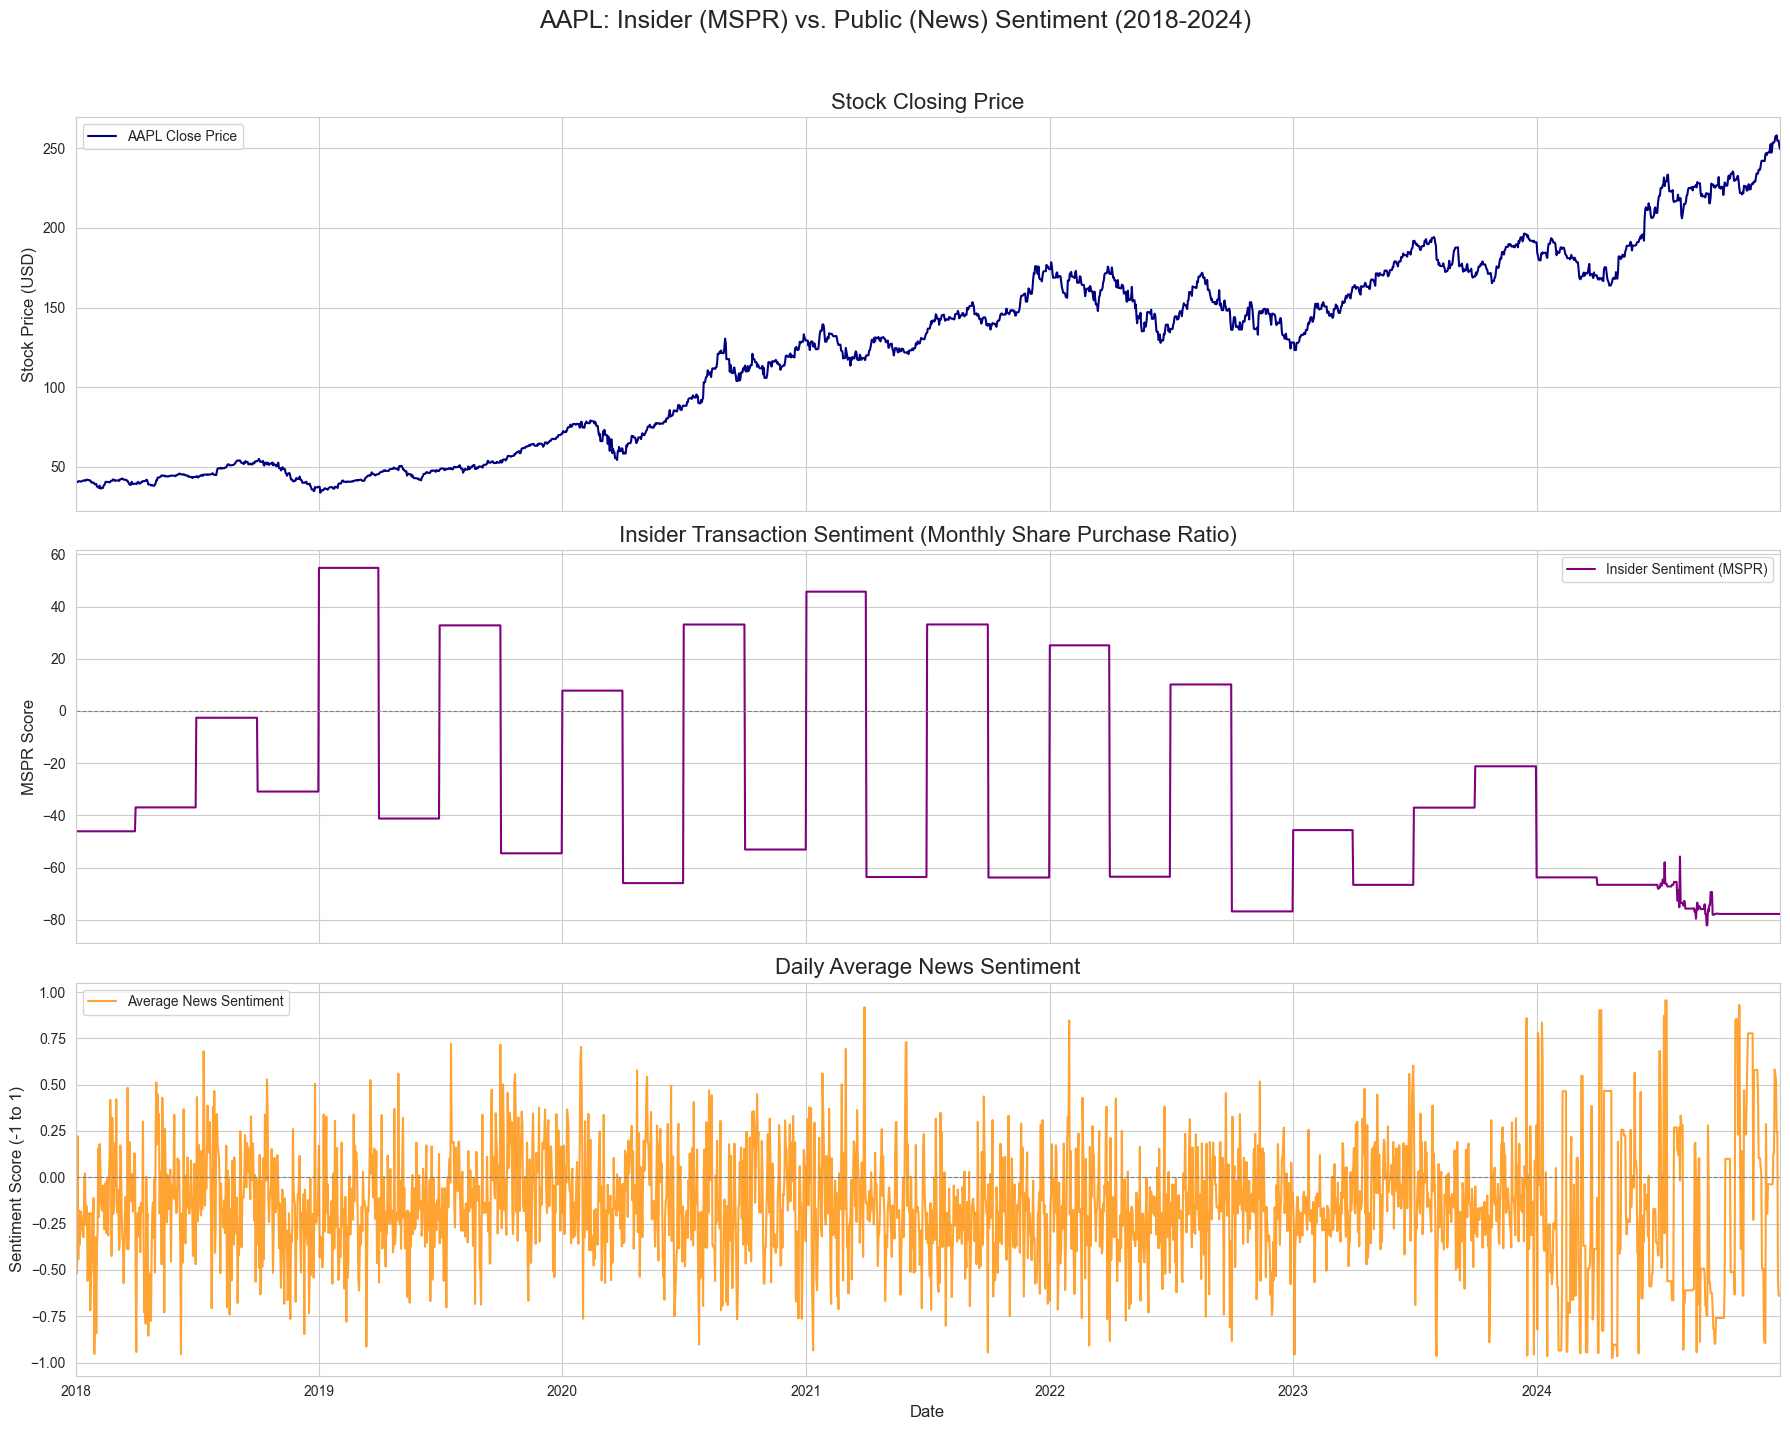

In [49]:
# 2.1.b.3: Insider vs. Public Sentiment
print("2.1.b.3: Plotting Insider vs. Public Sentiment for AAPL")
print("-"*30)

fig, axes = plt.subplots(3, 1, figsize=(18, 15), sharex=True)
fig.suptitle('AAPL: Insider (MSPR) vs. Public (News) Sentiment (2018-2024)', fontsize=18)

# --- FIX: Use the robust pandas plotting API ---
# Plot 1: Close Price
aapl_eda_df['Close'].plot(ax=axes[0], label='AAPL Close Price', color='navy')
axes[0].set_ylabel('Stock Price (USD)')
axes[0].set_title('Stock Closing Price')
axes[0].legend()
axes[0].grid(True)

# Plot 2: Insider Sentiment (MSPR)
aapl_eda_df['mspr'].plot(ax=axes[1], label='Insider Sentiment (MSPR)', color='purple')
axes[1].set_ylabel('MSPR Score')
axes[1].set_title('Insider Transaction Sentiment (Monthly Share Purchase Ratio)')
axes[1].axhline(0, color='grey', linestyle='--', linewidth=0.8)
axes[1].legend()
axes[1].grid(True)

# Plot 3: Average News Sentiment
aapl_eda_df['average_news_sentiment'].plot(ax=axes[2], label='Average News Sentiment', color='darkorange', alpha=0.8)
axes[2].set_ylabel('Sentiment Score (-1 to 1)')
axes[2].set_title('Daily Average News Sentiment')
axes[2].axhline(0, color='grey', linestyle='--', linewidth=0.8)
axes[2].legend()
axes[2].grid(True)

plt.xlabel('Date')
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

2.1.b.4: Plotting Corporate vs. Public Sentiment for AAPL
------------------------------


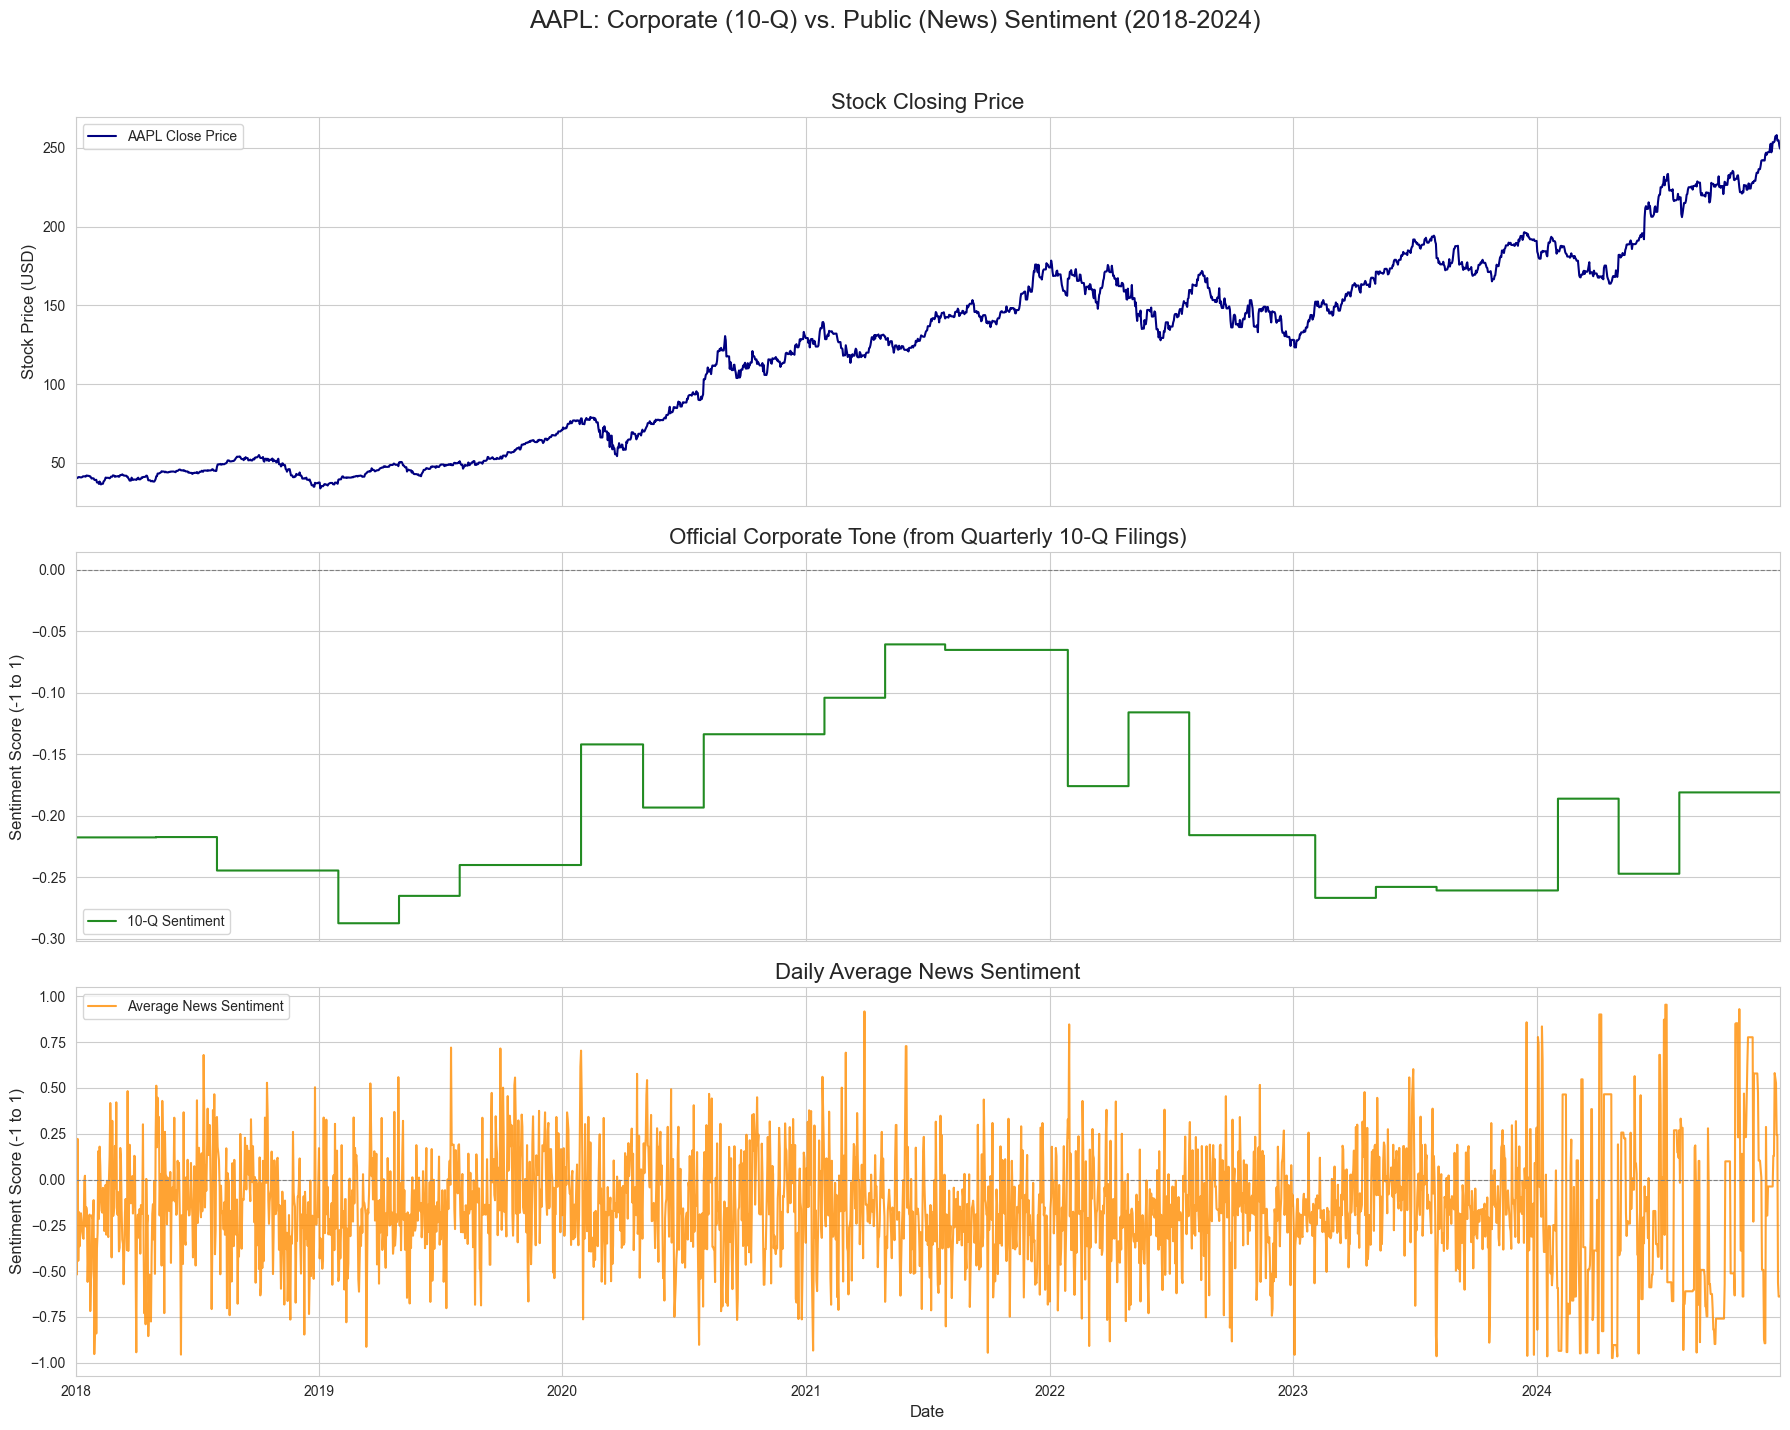

In [50]:
# 2.1.b.4: Corporate vs. Public Sentiment
print("2.1.b.4: Plotting Corporate vs. Public Sentiment for AAPL")
print("-"*30)

fig, axes = plt.subplots(3, 1, figsize=(18, 15), sharex=True)
fig.suptitle('AAPL: Corporate (10-Q) vs. Public (News) Sentiment (2018-2024)', fontsize=18)

# Plot 1: Close Price
aapl_eda_df['Close'].plot(ax=axes[0], label='AAPL Close Price', color='navy')
axes[0].set_ylabel('Stock Price (USD)')
axes[0].set_title('Stock Closing Price')
axes[0].legend()
axes[0].grid(True)

# Plot 2: 10-Q Sentiment
aapl_eda_df['10-Q_sentiment'].plot(ax=axes[1], label='10-Q Sentiment', color='forestgreen', drawstyle='steps-post')
axes[1].set_ylabel('Sentiment Score (-1 to 1)')
axes[1].set_title('Official Corporate Tone (from Quarterly 10-Q Filings)')
axes[1].axhline(0, color='grey', linestyle='--', linewidth=0.8)
axes[1].legend()
axes[1].grid(True)

# Plot 3: Average News Sentiment
aapl_eda_df['average_news_sentiment'].plot(ax=axes[2], label='Average News Sentiment', color='darkorange', alpha=0.8)
axes[2].set_ylabel('Sentiment Score (-1 to 1)')
axes[2].set_title('Daily Average News Sentiment')
axes[2].axhline(0, color='grey', linestyle='--', linewidth=0.8)
axes[2].legend()
axes[2].grid(True)

# Improve date formatting on the x-axis
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
axes[2].xaxis.set_major_locator(locator)
axes[2].xaxis.set_major_formatter(formatter)

plt.xlabel('Date')
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

### 2.2: EDA on NVDA Dataset

### 2.3: EDA on GOOGL Dataset

## Phase 3: Correlation Analysis with `Stockprices combined.xlsx`

### 3.1: AAPL vs `Stockprices combined`

### 3.2: NVDA vs `Stockprices combined`

### 3.3: GOOGL vs `Stockprices combined`

## Phase 4: Conclusions